# Libraries
---

In [1]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 45.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 102.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 M

In [2]:
!git clone https://github.com/josh-test-1120/HandGestures.git

fatal: destination path 'HandGestures' already exists and is not an empty directory.


In [2]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 92.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# System Libraires
import os
import pickle
import json
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
from scipy.interpolate import interp1d
import mne  # For multitaper PSD
from mne.time_frequency import psd_array_multitaper
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

import warnings

DATAFILES_DIR = 'HandGestures/backend/Datafiles'
MODELFILES_DIR = 'HandGestures/backend/Models'
UCIHARFILES_DIR = 'HandGestures/backend/UCI_HAR'
COLLECTIONFILES_DIR = 'HandGestures/backend/data-collections'

2025-06-09 09:15:30.820845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 09:15:30.845783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 09:15:30.845818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 09:15:30.861586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 09:15:31.682114: W tensorflow/compiler/tf

In [2]:
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'

# Base class for preprocessing of waveform data

This is the base class that contains most of the preprocessing work

In [3]:
class BaseDatasetLoader:
    def __init__(self, device=None, base_freq=50, target_len=127, **kwargs):
        self.device = device or (torch.device("mps") if torch.backends.mps.is_available() else
                                torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        # Waveform properties
        self.base_freq = base_freq
        self.target_len = target_len

        self.scales = range(1, 128)
        self.waveletname = 'morl'

        # Global stats
        self.global_mean = None
        self.global_std = None

        # Data packages
        self.train_segments = []
        self.test_segments = []
        self.label_dict = kwargs.get('label_dict', None)
        self.train_data = kwargs.get('train_data', None)
        self.train_labels = kwargs.get('train_labels', None)
        self.test_data = kwargs.get('test_data', None)
        self.test_labels = kwargs.get('test_labels', None)
        self.psd_train = kwargs.get('psd_train', None)
        self.psd_test = kwargs.get('psd_test', None)

        # Training packages
        self.x_train = kwargs.get('x_train', None)
        self.y_train = kwargs.get('y_train', None)
        self.x_test = kwargs.get('x_test', None)
        self.y_test = kwargs.get('y_test', None)

    def _normalize_signal(self, data, use_global=False):
        if use_global and self.global_mean is not None and self.global_std is not None:
            return (data - self.global_mean) / (self.global_std + 1e-6)
        return (data - np.median(data, axis=0)) / (np.std(data, axis=0) + 1e-6)

    def _resample_to_uniform(self, df, default_target_len=None, base_freq=None):
        base_freq = base_freq if base_freq is not None else self.base_freq
    
        timestamps = df['Timestamp(ms)'].values.astype(np.float64)
        cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
                'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
        signals = df[cols].values
    
        # Unique timestamps
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        duration_ms = timestamps[-1] - timestamps[0]
        duration_s = duration_ms / 1000.0
        est_freq = len(timestamps) / duration_s if duration_s > 0 else base_freq
        est_freq = np.clip(est_freq, 10, 200)
    
        if default_target_len is not None:
            target_len = default_target_len
        else:
            target_len = int(duration_s * base_freq)
            target_len = np.clip(target_len, 80, 160)
    
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], target_len)
        resampled = np.zeros((target_len, len(cols)))
    
        for i in range(len(cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
    
        return self._normalize_signal(resampled), 0  # Adjust start_index if needed

    def _compute_cwt(self, signal_1d):
        signal_1d = signal_1d - signal_1d.median()
        coeff, _ = pywt.cwt(signal_1d.cpu().numpy(), self.scales, self.waveletname, 1)
        tensor = torch.from_numpy(coeff[:, :self.target_len]).float().to(self.device)
        return self._normalize_cwt_tensor(tensor)

    def _normalize_cwt_tensor(self, cwt_tensor):
        mean = cwt_tensor.mean()
        std = cwt_tensor.std()
        return (cwt_tensor - mean) / (std + 1e-6)

    def _compute_psd_for_signal_welch(self, signal_1d, sfreq=50, nperseg=None):
        n_times = len(signal_1d)
        if nperseg is None:
            nperseg = min(256, n_times)
        freqs, psd = welch(signal_1d, fs=sfreq, nperseg=nperseg)
        return psd, freqs
    
    def _process_psd_dataset_welch(self, data, sfreq=50, target_length=127):
        num_samples, signal_length, num_channels = data.shape
    
        # Compute reference PSD for freq scale
        psd_ref, freqs_ref = self._compute_psd_for_signal_welch(data[0, :, 0], sfreq=sfreq)
        interp_freqs = np.linspace(freqs_ref[0], freqs_ref[-1], target_length)
    
        psd_dataset = np.zeros((num_samples, target_length, num_channels), dtype=np.float32)
    
        for i in tqdm(range(num_samples), desc="Welch PSD Samples"):
            for ch in range(num_channels):
                signal = data[i, :, ch]
                if len(signal) < 16:
                    psd_dataset[i, :, ch] = 0
                    continue
                psd, freqs = self._compute_psd_for_signal_welch(signal, sfreq=sfreq)
                interp_psd = np.interp(interp_freqs, freqs, psd)
                psd_dataset[i, :, ch] = interp_psd
    
        return psd_dataset


    def _compute_psd_for_signal_multitaper(self, signal_1d, sfreq=50, init_bandwidth=4.0, max_bandwidth=20.0):
        n_times = len(signal_1d)
        std = np.std(signal_1d)
        min_bandwidth = sfreq / n_times
    
        bandwidth = max(init_bandwidth, min_bandwidth)
        bandwidth_increment = 2.0  # How much to increase bandwidth on failure
    
        while bandwidth <= max_bandwidth:
            try:
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("always")
                    psd, freqs = mne.time_frequency.psd_array_multitaper(
                        signal_1d, sfreq=sfreq,
                        bandwidth=bandwidth,
                        adaptive=False,
                        normalization='full',
                        verbose=0
                    )
                    for warn in w:
                        if "did not converge" in str(warn.message):
                            # Warn but keep trying with higher bandwidth
                            raise RuntimeWarning(f"Multitaper PSD did not converge at bandwidth={bandwidth:.2f}")
    
                return psd
    
            except RuntimeWarning as rw:
                print(f"WARNING: multitaper PSD did not converge for signal (len={n_times}, std={std:.5f}, bandwidth={bandwidth:.2f})")
                bandwidth += bandwidth_increment
    
            except Exception as e:
                print(f"ERROR: multitaper PSD failed for signal (len={n_times}, std={std:.5f}, bandwidth={bandwidth:.2f}): {e}")
                bandwidth += bandwidth_increment
    
        print(f"FAILED: multitaper PSD did not converge after max bandwidth {max_bandwidth:.2f} for signal (len={n_times}, std={std:.5f})")
        raise RuntimeError(f"Multitaper PSD failed after trying bandwidths up to {max_bandwidth:.2f}")

    def _process_psd_dataset_multitaper(self, data, sfreq=50, target_length=390):
        num_samples, signal_length, num_channels = data.shape
        
        # Compute reference frequency scale
        psd_ref, freqs_ref = psd_array_multitaper(
            data[0, :, 0], sfreq=sfreq,
            adaptive=True, normalization='full', verbose=False
        )
        interp_freqs = np.linspace(freqs_ref[0], freqs_ref[-1], target_length)
    
        # Allocate output tensor
        psd_dataset = np.zeros((num_samples, target_length, num_channels), dtype=np.float32)
    
        for i in tqdm(range(num_samples), desc="Multitaper PSD Samples"):
            for ch in range(num_channels):
                signal = data[i, :, ch]
                if len(signal) < 16:
                    psd_dataset[i, :, ch] = 0
                    continue
                try:
                    psd, freqs = psd_array_multitaper(
                        signal, sfreq=sfreq,
                        adaptive=True, normalization='full', verbose=False
                    )
                    interp_psd = np.interp(interp_freqs, freqs, psd)
                    psd_dataset[i, :, ch] = interp_psd
                except Exception as e:
                    print(f"PSD failed for sample {i}, channel {ch}: {e}")
                    psd_dataset[i, :, ch] = 0
    
        return psd_dataset


    # def _process_psd_dataset_multitaper(self, data, sfreq=50, target_length=390):
    #     num_samples, signal_length, num_channels = data.shape
    #     example_psd = self._compute_psd_for_signal_multitaper(data[0, :, 0], sfreq=sfreq)
    #     original_psd_len = len(example_psd)
    #     # if target_length == None: target_length = original_psd_len
        
    #     psd_dataset = np.zeros((num_samples, target_length, num_channels), dtype=np.float32)
    
    #     for i in tqdm(range(num_samples), desc="Multitaper PSD Samples"):
    #         for ch in range(num_channels):
    #             signal = data[i, :, ch]
    #             if len(signal) < 16:
    #                 psd_dataset[i, :, ch] = 0
    #                 continue
    #             try:
    #                 psd = self._compute_psd_for_signal_multitaper(signal, sfreq=sfreq)
    #                 interp_psd = np.interp(
    #                     np.linspace(0, len(psd)-1, target_length),
    #                     np.arange(len(psd)),
    #                     psd
    #                 )
    #                 psd_dataset[i, :, ch] = interp_psd
    #             except Exception as e:
    #                 print(f"PSD failed for sample {i}, channel {ch}: {e}")
    #                 psd_dataset[i, :, ch] = 0
    
    #     return psd_dataset

    def _process_dataset_tensor(self, data, batch_size=32):
        num_samples, signal_length, num_channels = data.shape
        result = torch.zeros((num_samples, self.target_len, self.target_len, num_channels), device=self.device)

        for ch in range(num_channels):
            print(f"Processing channel {ch + 1}/{num_channels}")
            for i in tqdm(range(0, num_samples, batch_size)):
                batch = data[i:i + batch_size, :, ch]
                batch_tensor = torch.from_numpy(batch).float().to(self.device)
                for k in range(batch_tensor.shape[0]):
                    result[i + k, :, :, ch] = self._compute_cwt(batch_tensor[k])
        return result.cpu().numpy()

    def _process_cwt(self, train_data, test_data):
        # Compute and save CWT datasets
        print("\nProcessing CWT for training data...")
        x_train = self.process_dataset_tensor(self.train_data)
        y_train = self.train_labels[:len(x_train)]
    
        print("\nProcessing CWT for test data...")
        x_test = self.process_dataset_tensor(self.test_data)
        y_test = self.test_labels[:len(x_test)]
        
    def save_processed_files(self):
        # Make sure the data directory exists (create if it does not)
        os.makedirs(self.datafiles_dir, exist_ok=True)
        
        # Save raw dataset before any preprocessing
        raw_dataset = {
            "train_data": torch.tensor(self.train_data, dtype=torch.float32),
            "train_labels": self.train_labels,
            "test_data": torch.tensor(self.test_data, dtype=torch.float32),
            "test_labels": self.test_labels,
            "label_dict": self.label_dict
        }
        raw_path = os.path.join(self.datafiles_dir, f"raw_{self._get_save_prefix()}_6channels_dataset.pt")
        torch.save(raw_dataset, raw_path)
        print(f"Raw dataset saved to {raw_path}")
    
        # Save metadata (file paths and segments)
        metadata_path = os.path.join(self.datafiles_dir, f"raw_{self._get_save_prefix()}_metadata.pkl")
        with open(metadata_path, "wb") as f:
            pickle.dump({
                "train_segments": self.train_segments,
                "test_segments": self.test_segments
            }, f)
        print(f"Raw file paths saved to {metadata_path}")

        # Save PSD preprocessed data from raw dataset
        psd_path = os.path.join(self.datafiles_dir, f"psd_{self._get_save_prefix()}_6channels_dataset.pt")
        torch.save({
            "psd_train": torch.tensor(self.psd_train),
            "train_labels": self.train_labels,
            "psd_test": torch.tensor(self.psd_test),
            "test_labels": self.test_labels,
            "label_dict": self.label_dict
        }, psd_path)
        print(f"PSD dataset saved to {psd_path}")

        # Save CWT preprocessed data from raw dataset
        cwt_path = os.path.join(self.datafiles_dir, f"cwt_{self._get_save_prefix()}_6channels_dataset.pt")
        torch.save({
            "x_train": torch.tensor(self.x_train),
            "y_train": self.y_train,
            "x_test": torch.tensor(self.x_test),
            "y_test": self.y_test,
            "label_dict": self.label_dict
        }, cwt_path)
        print(f"CWT dataset saved to {cwt_path}\n")

        # Final output of training shapes
        print(f"x_train shape: {self.x_train.shape}")
        print(f"y_train shape: {self.y_train.shape}")
        print(f"x_test shape: {self.x_test.shape}")
        print(f"y_test shape: {self.y_test.shape}")

    def _get_save_prefix(self):
        # Can be overridden by subclasses to differentiate save filenames
        return "dataset"

class UCIHARDatasetLoader(BaseDatasetLoader):
    def __init__(self, root_dir, datafiles_dir, **kwargs):
        super().__init__(**kwargs)
        self.root_dir = root_dir
        self.datafiles_dir = datafiles_dir

        self.train_signals_dir = os.path.join(root_dir, "train", "Inertial Signals")
        self.test_signals_dir = os.path.join(root_dir, "test", "Inertial Signals")
        self.train_label_file = os.path.join(root_dir, "train", "y_train.txt")
        self.test_label_file = os.path.join(root_dir, "test", "y_test.txt")
        self.activity_label_file = os.path.join(root_dir, "activity_labels.txt")

        self.signal_files = ['body_acc_x_', 'body_acc_y_', 'body_acc_z_',
                             'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_']

    def _get_save_prefix(self):
        return "UCI_HAR"

    def run_full_preprocessing(self, target_len=127):
        print("Loading and splitting dataset...")
        self._load_and_split_dataset()
    
        print("Processing PSD dataset...")
        self.psd_train = self._process_psd_dataset_welch(self.train_data)
        self.psd_test = self._process_psd_dataset_welch(self.test_data)
    
        print("\nProcessing CWT for training data...")
        self.x_train = self._process_dataset_tensor(self.train_data)
        self.y_train = self.train_labels[:len(self.x_train)]
    
        print("\nProcessing CWT for test data...")
        self.x_test = self._process_dataset_tensor(self.test_data)
        self.y_test = self.test_labels[:len(self.x_test)]
    
        print(f"\nx_train shape: {self.x_train.shape}")
        print(f"y_train shape: {self.y_train.shape}")
        print(f"x_test shape: {self.x_test.shape}")
        print(f"y_test shape: {self.y_test.shape}")

    def _load_and_split_dataset(self, train_ratio=0.8, seed=42):
        # Load training signals
        train_signals = []
        for sf in self.signal_files:
            file_path = os.path.join(self.train_signals_dir, sf + "train.txt")
            train_signals.append(self._read_signals(file_path))
        train_signals = np.transpose(np.array(train_signals), (1, 2, 0))  # shape: [samples, timesteps, features]

        # Load test signals
        test_signals = []
        for sf in self.signal_files:
            file_path = os.path.join(self.test_signals_dir, sf + "test.txt")
            test_signals.append(self._read_signals(file_path))
        test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

        # Load labels
        self.train_labels = self._read_labels(self.train_label_file)
        self.test_labels = self._read_labels(self.test_label_file)

        # Randomize / shuffle dataset
        self.train_data, self.train_labels = self._randomize(train_signals, self.train_labels, seed)
        self.test_data, self.test_labels = self._randomize(test_signals, self.test_labels, seed)

        # Load activity labels (for human-readable mapping)
        self.label_dict = self._load_activity_labels(self.activity_label_file)

        # Save activity label dict json for reference
        labels_path = os.path.join(self.datafiles_dir, f"label_index_map_{self._get_save_prefix()}.json")
        with open(labels_path, "w") as f:
            json.dump(self.label_dict, f, indent=4)
        print(f"Activity label dictionary saved to {labels_path}")

        print(f"Number of training samples: {len(self.train_data)}")
        print(f"Number of test samples: {len(self.test_data)}")

    def _read_signals(self, filename):
        with open(filename, 'r') as fp:
            data = fp.read().splitlines()
            data = [list(map(float, line.strip().split())) for line in data]
            return np.array(data, dtype=np.float32)

    def _read_labels(self, filename):
        with open(filename, 'r') as fp:
            labels = fp.read().splitlines()
            labels = list(map(int, labels))
            # Convert labels to zero-based indexing (0..N-1)
            labels = np.array(labels) - 1
            return labels

    def _randomize(self, data, labels, seed):
        np.random.seed(seed)
        permutation = np.random.permutation(labels.shape[0])
        return data[permutation], labels[permutation]

    def _load_activity_labels(self, filename):
        activity_labels = {}
        with open(filename, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    idx = int(parts[0]) - 1  # zero-based index
                    label = " ".join(parts[1:])
                    activity_labels[idx] = label
        return activity_labels

    # --- Optional: original CSV batch loading functions retained but NOT used for UCI HAR ---
    def _load_batch(self, paths):
        all_data = []
        for p in paths:
            data = self._extract_tensor_from_csv(p)
            all_data.append(data)
        return np.stack(all_data)

    def _extract_tensor_from_csv(self, csv_path):
        import pandas as pd
        df = pd.read_csv(csv_path)
        data, _ = self._resample_to_uniform(df)  # assuming implemented in BaseDatasetLoader
        return data.astype(np.float32)

class HandGesturesDatasetLoader(BaseDatasetLoader):
    def __init__(self, collections_dir, datafiles_dir, train_ratio=0.8, seed=42, label_map=None, **kwargs):
        super().__init__(**kwargs)
        self.collections_dir = collections_dir  # directory for raw dataset files (reading)
        self.datafiles_dir = datafiles_dir      # directory for saving intermediate data (writing)

        self.train_ratio = train_ratio
        self.seed = seed
        self.label_map = label_map
        self.mapped_labels = True if label_map else False

    def _get_save_prefix(self):
        return "handgestures"

    def run_full_preprocessing(self, target_len=127):
        print("Loading and splitting dataset...")
        self._load_and_split_dataset()
    
        print("Processing PSD dataset...")
        self.psd_train = self._process_psd_dataset_welch(self.train_data)
        self.psd_test = self._process_psd_dataset_welch(self.test_data)
    
        print("\nProcessing CWT for training data...")
        self.x_train = self._process_dataset_tensor(self.train_data)
        self.y_train = self.train_labels[:len(self.x_train)]
    
        print("\nProcessing CWT for test data...")
        self.x_test = self._process_dataset_tensor(self.test_data)
        self.y_test = self.test_labels[:len(self.x_test)]
    
        print(f"\nx_train shape: {self.x_train.shape}")
        print(f"y_train shape: {self.y_train.shape}")
        print(f"x_test shape: {self.x_test.shape}")
        print(f"y_test shape: {self.y_test.shape}")

    def _load_and_split_dataset(self):
        # Load the canonical label dict from the saved JSON file
        labels_path = os.path.join(self.datafiles_dir, f"label_index_map_UCI_HAR.json")
        with open(labels_path, "r") as f:
            canonical_label_dict = json.load(f)  # keys are strings of indices, values are labels
        
        # Sort the canonical labels by their original index (int)
        sorted_indices = sorted(canonical_label_dict.keys(), key=int)
        canonical_labels_ordered = [canonical_label_dict[idx] for idx in sorted_indices]
        
        mapped_labels_list = []
        file_paths_filtered = []
    
        for root, _, files in os.walk(self.collections_dir):
            for file in files:
                if not file.lower().endswith(".csv"):
                    continue
    
                path = os.path.join(root, file)
                path_parts = os.path.normpath(root).split(os.sep)
    
                if len(path_parts) < 2:
                    continue
    
                if path_parts[-1].lower() == "variants":
                    if len(path_parts) < 3:
                        continue
                    classifier, behavior = path_parts[-3], path_parts[-2]
                elif len(path_parts) >= 2 and path_parts[-2].lower() == "variants":
                    if len(path_parts) < 4:
                        continue
                    classifier, behavior = path_parts[-4], path_parts[-3]
                else:
                    classifier, behavior = path_parts[-2], path_parts[-1]
    
                original_label = f"{classifier}_{behavior}"
    
                if self.label_map is not None:
                    mapped_label = self.label_map.get(original_label, None)
                    if mapped_label is None:
                        continue
                else:
                    mapped_label = original_label
    
                mapped_labels_list.append(mapped_label)
                file_paths_filtered.append(path)
    
        # Ensure all canonical labels are included, even if unused
        used_labels = set(mapped_labels_list)
        for label in canonical_labels_ordered:
            if label not in used_labels:
                used_labels.add(label)
    
        # Build label_dict preserving the canonical label order
        self.label_dict = {label: idx for idx, label in enumerate(canonical_labels_ordered)}
    
        # Map labels to their indices based on the canonical label_dict
        labels_idx = [self.label_dict[lbl] for lbl in mapped_labels_list]
    
        paths = np.array(file_paths_filtered)
        labels = np.array(labels_idx)
        print(f"These are the CSV files used in labeling: {len(paths)}")
    
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            paths, labels, train_size=self.train_ratio, random_state=self.seed, stratify=labels
        )
    
        self.train_data = self._load_batch_with_tracking(train_paths, is_train=True)
        self.test_data = self._load_batch_with_tracking(test_paths, is_train=False)
        self.train_labels = train_labels
        self.test_labels = test_labels
    
        # Save the label dictionary again (optional, but consistent)
        with open(labels_path, "w") as f:
            json.dump(self.label_dict, f, indent=4)
        print(f"Activity label dictionary saved to {labels_path}")
    
        print(f"Number of training samples: {len(self.train_data)}")
        print(f"Number of test samples: {len(self.test_data)}")


    def _load_batch_with_tracking(self, paths, is_train=True):
        all_data = []
        segment_list = self.train_segments if is_train else self.test_segments
        for i, p in enumerate(paths):
            data, idx = self._extract_tensor_from_csv_with_index(p)
            all_data.append(data)
            segment_list.append({"file": p, "start_index": idx, "tensor_index": len(all_data) - 1})
        return np.stack(all_data)

    def _extract_tensor_from_csv_with_index(self, csv_path, target_len=127):
        df = pd.read_csv(csv_path)
        data, start_index = self._resample_to_uniform(df, default_target_len=target_len)
        return data.astype(np.float32), start_index

    def _resample_to_uniform(self, df, default_target_len=None, base_freq=None):
        base_freq = base_freq if base_freq is not None else self.base_freq

        timestamps = df['Timestamp(ms)'].values.astype(np.float64)
        cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
                'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
        signals = df[cols].values

        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        duration_ms = timestamps[-1] - timestamps[0]
        duration_s = duration_ms / 1000.0
        est_freq = len(timestamps) / duration_s if duration_s > 0 else base_freq
        est_freq = np.clip(est_freq, 10, 200)

        if default_target_len is not None:
            target_len = default_target_len
        else:
            target_len = int(duration_s * base_freq)
            target_len = np.clip(target_len, 80, 160)

        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], target_len)
        resampled = np.zeros((target_len, len(cols)))

        for i in range(len(cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return self._normalize_signal(resampled), 0

    def _normalize_signal(self, signal):
        # Dummy example: normalize to zero mean, unit std
        return (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-6)

In [11]:
# Instantiate loader WITHOUT label_file argument (it's handled internally)
uci_loader = UCIHARDatasetLoader(
    root_dir=UCIHARFILES_DIR,
    datafiles_dir=DATAFILES_DIR
)

# Load dataset (train/test signals and labels)
uci_loader.run_full_preprocessing()

# Save processed datasets
uci_loader.save_processed_files()

# Get the data from the instance
x_train = uci_loader.x_train
y_train = uci_loader.y_train
x_test = uci_loader.x_test
y_test = uci_loader.y_test
label_dict = uci_loader.label_dict
psd_train = uci_loader.psd_train
train_labels = uci_loader.train_labels
psd_test = uci_loader.psd_test
test_labels = uci_loader.test_labels

Loading and splitting dataset...

x_train shape: (7352, 127, 127, 6)
y_train shape: (7352,)
x_test shape: (2947, 127, 127, 6)
y_test shape: (2947,)
Raw dataset saved to HandGestures/backend/Datafiles/raw_UCI_HAR_6channels_dataset.pt
Raw file paths saved to HandGestures/backend/Datafiles/raw_UCI_HAR_metadata.pkl
PSD dataset saved to HandGestures/backend/Datafiles/psd_UCI_HAR_6channels_dataset.pt
CWT dataset saved to HandGestures/backend/Datafiles/cwt_UCI_HAR_6channels_dataset.pt

x_train shape: (7352, 127, 127, 6)
y_train shape: (7352,)
x_test shape: (2947, 127, 127, 6)
y_test shape: (2947,)


100%|██████████| 93/93 [00:19<00:00,  4.75it/s]


In [12]:
# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_UCI_HAR_6channels_dataset.pt", map_location="cpu", weights_only=False)  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

In [13]:
# Load the dataset
data = torch.load(f"{DATAFILES_DIR}/psd_UCI_HAR_6channels_dataset.pt", weights_only=False)

# Extract variables
psd_train = data["psd_train"]
train_labels = data["train_labels"]
psd_test = data["psd_test"]
test_labels = data["test_labels"]
label_dict = data["label_dict"]

# Train the UCI HAR Dataset

This is pretraining of the UCI HAR Dataset to be used in the training of the HandGestures Dataset

In [14]:
class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x: [B, T, hidden_dim]
        weights = self.attn(x)  # [B, T, 1]
        weights = torch.softmax(weights, dim=1)  # attention weights over time
        weighted_sum = (x * weights).sum(dim=1)  # [B, hidden_dim]
        return weighted_sum

class CNNLSTMWithPSD(nn.Module):
    def __init__(self, input_channels, input_shape, psd_dim, num_classes, lstm_hidden=192, lstm_layers=1, bidirectional=True):
        super().__init__()
        H, W = input_shape

        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),

            nn.AdaptiveAvgPool2d(1)  # output: (B, 128, 1, 1)
        )

        # Calculate flattened CNN output size
        dummy_input = torch.zeros(1, input_channels, H, W)
        cnn_out = self.cnn(dummy_input)
        cnn_output_dim = cnn_out.view(1, -1).size(1)  # should be 128 here

        self.ln = nn.LayerNorm(cnn_output_dim)

        self.lstm = nn.LSTM(
            input_size=cnn_output_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        lstm_out_dim = lstm_hidden * (2 if bidirectional else 1)

        self.attention_pool = AttentionPool(lstm_out_dim)

        self.psd_ln = nn.LayerNorm(psd_dim)

        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_out_dim + 64, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, psd):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)
        x = x.view(B, T, -1)  # shape: (B, T, cnn_output_dim)
        x = self.ln(x)

        lstm_out, _ = self.lstm(x)  # (B, T, lstm_hidden * num_directions)
        attn_out = self.attention_pool(lstm_out)  # (B, lstm_hidden * num_directions)

        psd = self.psd_ln(psd)  # LayerNorm PSD input
        psd_out = self.psd_branch(psd)  # (B, 64)

        fused = torch.cat([attn_out, psd_out], dim=1)  # (B, lstm_out_dim + 64)
        out = self.classifier(fused)
        return out

In [16]:
# --- Memory Configuration (must come first) ---
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# --- Device and Seed Setup ---
torch.manual_seed(42)
np.random.seed(42)
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# Better randomization and memory allocation
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# --- Your Dataset Variables (make sure these are loaded before) ---
# x_train, y_train, x_test, y_test, psd_train, psd_test
input_shape = (127, 127, 6)
batch_size = 16
epochs = 25
accumulation_steps = 2
time_steps = 8

# --- Label mapping ---
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

def map_labels(y, mapping):
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)
num_classes = len(label_to_index)

# --- Safe tensor conversion ---
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# --- Padding function ---
def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # ignore_index
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

# --- Reshape into sequences ---
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

# Use only last timestep labels and PSD
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

psd_train_seq_padded = psd_train_seq[:, -1, :]
psd_test_seq_padded = psd_test_seq[:, -1, :]

# Move tensors to device
x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_padded = psd_train_seq_padded.to(device)
psd_test_seq_padded = psd_test_seq_padded.to(device)

psd_vector_dim = psd_train_seq_padded.shape[1]

model = CNNLSTMWithPSD(input_channels=6, input_shape=(127, 127), psd_dim=psd_vector_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# --- DataLoaders ---
train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_padded, y_train_seq_last),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_padded, y_test_seq_last),
                         batch_size=batch_size)

# --- Training Loop ---
total_time = time()

history = defaultdict(list)
for epoch in range(epochs):
    epoch_start = time()
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    train_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    train_time = time() - train_start

    scheduler.step()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_start = time()
    with torch.no_grad():
        for batch_idx, (inputs, psds, labels) in enumerate(test_loader):
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
            del inputs, psds, labels, outputs, mask, predicted
            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    val_time = time() - val_start

    epoch_time = time() - epoch_start

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    history['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    print()

# --- Safe evaluation function ---
def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            # SAFE cleanup
            del chunk_inputs, chunk_psds, chunk_labels, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    return total_loss / total, correct / total if total > 0 else 0

# --- Final evaluation ---
train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_padded, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_padded, y_test_seq_last)

total_time = time() - total_time

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Total Training time: {total_time:.2f} seconds")
print_memory_stats("Final")

Using device: cuda
Epoch 1/25 - 6.7s
Train Loss: 1.3688 Acc: 0.4940
Val Loss: nan Acc: 0.6522

Epoch 2/25 - 6.8s
Train Loss: 0.7759 Acc: 0.6333
Val Loss: nan Acc: 0.6658

Epoch 3/25 - 6.8s
Train Loss: 0.5622 Acc: 0.7432
Val Loss: nan Acc: 0.7092

Epoch 4/25 - 6.8s
Train Loss: 0.4753 Acc: 0.8183
Val Loss: nan Acc: 0.7418

Epoch 5/25 - 6.8s
Train Loss: 0.3803 Acc: 0.8607
Val Loss: nan Acc: 0.7310

Epoch 6/25 - 6.8s
Train Loss: 0.2735 Acc: 0.9032
Val Loss: nan Acc: 0.7446

Epoch 7/25 - 6.8s
Train Loss: 0.2020 Acc: 0.9282
Val Loss: nan Acc: 0.7636

Epoch 8/25 - 6.8s
Train Loss: 0.1169 Acc: 0.9576
Val Loss: nan Acc: 0.7092

Epoch 9/25 - 6.8s
Train Loss: 0.0964 Acc: 0.9652
Val Loss: nan Acc: 0.7663

Epoch 10/25 - 6.8s
Train Loss: 0.0845 Acc: 0.9771
Val Loss: nan Acc: 0.7473

Epoch 11/25 - 6.9s
Train Loss: 0.0735 Acc: 0.9739
Val Loss: nan Acc: 0.7283

Epoch 12/25 - 6.9s
Train Loss: 0.0346 Acc: 0.9902
Val Loss: nan Acc: 0.7065

Epoch 13/25 - 6.9s
Train Loss: 0.0285 Acc: 0.9913
Val Loss: nan Ac

In [17]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/UCIHAR_pretrained-6_channel_CNN-LSTM-PSD_model_weights_100percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/UCIHAR_pretrained-6_channel_CNN-LSTM-PSD_model_weights_100percent.csv", index=False)

# Preprocess HandGesture Dataset
---

In [18]:
label_map_pretrain = {
    # Tremor (exclude running/falling)
    'tremor_walking': 'WALKING',
    'tremor_standing': 'STANDING',
    'tremor_sitting': 'SITTING',
    'tremor_laying': 'LAYING',
    'tremor_stairs': 'WALKING_UPSTAIRS',
    # Postural
    'postural_walking': 'WALKING',
    'postural_standing': 'STANDING',
    'postural_sitting': 'SITTING',
    'postural_laying': 'LAYING',
    'postural_stairs': 'WALKING_UPSTAIRS',
    # Normal
    'normal_walking': 'WALKING',
    'normal_standing': 'STANDING',
    'normal_sitting': 'SITTING',
    'normal_laying': 'LAYING',
    'normal_stairs': 'WALKING_UPSTAIRS',
    # Tonic
    'tonic_walking': 'WALKING',
    'tonic_standing': 'STANDING',
    'tonic_sitting': 'SITTING',
    'tonic_laying': 'LAYING',
    'tonic_stairs': 'WALKING_UPSTAIRS',
}

label_map_fulltrain = {
    # Tremor
    'tremor_running': 'WALKING',
    'tremor_falling': 'WALKING',
    'tremor_walking': 'WALKING',
    'tremor_standing': 'STANDING',
    'tremor_sitting': 'SITTING',
    'tremor_laying': 'LAYING',
    'tremor_stairs': 'WALKING_UPSTAIRS',
    # Postural
    'postural_running': 'WALKING',
    'postural_falling': 'WALKING',
    'postural_walking': 'WALKING',
    'postural_standing': 'STANDING',
    'postural_sitting': 'SITTING',
    'postural_laying': 'LAYING',
    'postural_stairs': 'WALKING_UPSTAIRS',
    # Normal
    'normal_running': 'WALKING',
    'normal_falling': 'WALKING',
    'normal_walking': 'WALKING',
    'normal_standing': 'STANDING',
    'normal_sitting': 'SITTING',
    'normal_laying': 'LAYING',
    'normal_stairs': 'WALKING_UPSTAIRS',
    # Tonic
    'tonic_running': 'WALKING',
    'tonic_falling': 'WALKING',
    'tonic_walking': 'WALKING',
    'tonic_standing': 'STANDING',
    'tonic_sitting': 'SITTING',
    'tonic_laying': 'LAYING',
    'tonic_stairs': 'WALKING_UPSTAIRS',
}

In [ ]:
reduced_labels = [k for k in label_map_fulltrain.keys() if k not in label_map_pretrain.keys()]
print(f'Using a filtered set of labels. Here are the labels that are removed: {reduced_labels}')

# Handsgesture dataset loading
handsGestureLoader = HandGesturesDatasetLoader(
    datafiles_dir=DATAFILES_DIR,
    label_map=label_map_pretrain,
    # label_map=label_map_fulltrain,
    collections_dir=COLLECTIONFILES_DIR,
)
handsGestureLoader.run_full_preprocessing()

handsGestureLoader.save_processed_files()

x_train = handsGestureLoader.x_train
y_train = handsGestureLoader.y_train
x_test = handsGestureLoader.x_test
y_test = handsGestureLoader.y_test
label_dict = handsGestureLoader.label_dict
psd_train = handsGestureLoader.psd_train
train_labels = handsGestureLoader.train_labels
psd_test = handsGestureLoader.psd_test
test_labels = handsGestureLoader.test_labels

In [ ]:
# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

In [ ]:
# Load the dataset
data = torch.load(f"{DATAFILES_DIR}/psd_handgestures_6channels_dataset.pt", weights_only=False)

# Extract variables
psd_train = data["psd_train"]
train_labels = data["train_labels"]
psd_test = data["psd_test"]
test_labels = data["test_labels"]
label_dict = data["label_dict"]

In [14]:
# Load the index to fine label map from JSON
with open(f"{DATAFILES_DIR}/label_index_map_handgestures.json", "r") as f:
    index_to_label_fine = json.load(f)  # expects something like {"0": "tremor_walking", "1": "tremor_standing", ...}

index_to_label_fine['WALKING_DOWNSTAIRS'] = 5

# Invert it to get index-to-label mapping
index_to_label_fine = {v: k for k, v in index_to_label_fine.items()}

print(index_to_label_fine)
print(len(index_to_label_fine))

{0: 'LAYING', 1: 'SITTING', 2: 'STANDING', 3: 'WALKING', 4: 'WALKING_UPSTAIRS', 5: 'WALKING_DOWNSTAIRS'}
6


In [ ]:
# --- Memory Configuration (must come first) ---
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# --- Device and Seed Setup ---
torch.manual_seed(42)
np.random.seed(42)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# --- Dataset Config ---
input_shape = (127, 127, 6)
batch_size = 16
epochs = 10
accumulation_steps = 2
time_steps = 8

# Load the index to fine label map from JSON
with open(f"{DATAFILES_DIR}/label_index_map_handgestures.json", "r") as f:
    index_to_label_fine = json.load(f)  # expects something like {"0": "tremor_walking", "1": "tremor_standing", ...}

# index_to_label_fine['WALKING_DOWNSTAIRS'] = 5

# Invert it to get index-to-label mapping
index_to_label_fine = {v: k for k, v in index_to_label_fine.items()}

# num_classes = len(index_to_label_fine)

# Convert integer indices to fine-grained labels
y_train_labels = [index_to_label_fine[int(i)] for i in y_train]
y_test_labels = [index_to_label_fine[int(i)] for i in y_test]

# Invert it to get index-to-label mapping
label_map_pretrain_reversed = {v: k for k, v in label_map_pretrain.items()}
label_map_pretrain_reversed['WALKING_DOWNSTAIRS'] = 'WALKING_UPSTAIRS'

# Map fine-grained labels to coarse labels using your label_map_pretrain
# print(y_train_labels)
y_train_coarse = np.array([label_map_pretrain_reversed[label] for label in y_train_labels])
y_test_coarse = np.array([label_map_pretrain_reversed[label] for label in y_test_labels])

# --- Coarse label conversion ---
# y_train_coarse = np.array([label_map_pretrain[label] for label in y_train])
# y_test_coarse = np.array([label_map_pretrain[label] for label in y_test])

# --- Label indexing ---
y_all = np.concatenate([y_train_coarse, y_test_coarse])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

index_to_label = {idx: label for label, idx in label_to_index.items()}
print(label_to_index)
# index_to_label['WALKING_DOWNSTAIRS'] = 'WALKING_UPSTAIRS'

def map_labels(y, mapping):
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train_coarse, label_to_index)
y_test_idx = map_labels(y_test_coarse, label_to_index)
num_classes = len(index_to_label)
print(f'Length of classes: {num_classes}')

# --- Tensor Conversion ---
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# --- Padding ---
def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

# --- Reshape ---
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

# --- Use last timestep for prediction ---
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]
psd_train_seq_padded = psd_train_seq[:, -1, :]
psd_test_seq_padded = psd_test_seq[:, -1, :]

# --- Device transfer ---
x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_padded = psd_train_seq_padded.to(device)
psd_test_seq_padded = psd_test_seq_padded.to(device)

psd_vector_dim = psd_train_seq_padded.shape[1]

# --- Load Pretrained Encoder, Replace Classifier ---
pretrained_model_path = f"{MODELFILES_DIR}/UCIHAR_pretrained_6-channel_CNN-LSTM-PSD_model_weights_100percent.pt"

# Step 1: Load with dummy num_classes to allow loading weights
model = CNNLSTMWithPSD(
    input_channels=6,
    input_shape=(127, 127),
    psd_dim=psd_vector_dim,
    num_classes=num_classes  # number of classes in handgestures dataset
).to(device)

# Step 2: Load the pretrained weights except the classifier
state_dict = torch.load(pretrained_model_path, map_location=device)

model.load_state_dict(state_dict, strict=False)  # skip classifier

# Step 3: Replace classifier for new task
model.classifier = nn.Sequential(
    nn.Linear(192 * 2 + 64, 64),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(64, num_classes)
).to(device)

# Optional: Freeze encoder layers to train classifier only
# for param in model.cnn.parameters(): param.requires_grad = False
# for param in model.lstm.parameters(): param.requires_grad = False
# for param in model.psd_branch.parameters(): param.requires_grad = False

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# --- DataLoaders ---
train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_padded, y_train_seq_last),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_padded, y_test_seq_last),
                         batch_size=batch_size)

# --- Training Loop ---
total_time = time()

history = defaultdict(list)
for epoch in range(epochs):
    epoch_start = time()
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    train_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    train_time = time() - train_start

    scheduler.step()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_start = time()
    with torch.no_grad():
        for batch_idx, (inputs, psds, labels) in enumerate(test_loader):
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
            del inputs, psds, labels, outputs, mask, predicted
            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    val_time = time() - val_start

    epoch_time = time() - epoch_start

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    history['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    print()

# --- Safe evaluation function ---
def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            torch.mps.empty_cache()
            # SAFE cleanup
            del chunk_inputs, chunk_psds, chunk_labels, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    return total_loss / total, correct / total if total > 0 else 0

# --- Final evaluation ---
train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_padded, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_padded, y_test_seq_last)

total_time = time() - total_time

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Total Training time: {total_time:.2f} seconds")
print_memory_stats("Final")

In [ ]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/UCIHAR_pretrained-handgesture_trained-6_channel_CNN-LSTM-PSD_model_weights_100percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/UCIHAR_pretrained-handgesture_trained-6_channel_CNN-LSTM-PSD_model_weights_100percent.csv", index=False)

In [20]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data
 
def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)
 
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
 
####
 
INPUT_FOLDER_TRAIN = f'{UCIHARFILES_DIR}/train/Inertial Signals/'
INPUT_FOLDER_TEST = f'{UCIHARFILES_DIR}/test/Inertial Signals/'
 
INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
 
INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
 
#####
 
train_signals, test_signals = [], []
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
 
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
 
#####
 
LABELFILE_TRAIN = f'{UCIHARFILES_DIR}/train/y_train.txt'
LABELFILE_TEST = f'{UCIHARFILES_DIR}/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)
 
#####
 
train_data, train_labels = randomize(train_signals, train_labels)
test_data, test_labels = randomize(test_signals, test_labels)

# Load activity labels into a dict {index: label_name}
activity_labels = {}
with open(f'{UCIHARFILES_DIR}/activity_labels.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            idx = int(parts[0])
            label = " ".join(parts[1:])
            activity_labels[idx] = label

print(activity_labels)
# Example output: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', ...}

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


## Random Prediction

Pick a random sample from the UCI HAR wavelets and do a prediction

In [33]:
import torch
import numpy as np
import pywt
import random
from scipy.signal import welch

# -- Wavelet Transform Parameters --
scales = range(1, 128)
wavelet = 'morl'

# -- CWT computation --
def compute_cwt(signal_1d, device, scales=scales, wavelet=wavelet):
    signal_np = signal_1d.cpu().numpy() if isinstance(signal_1d, torch.Tensor) else signal_1d
    coeff, _ = pywt.cwt(signal_np, scales, wavelet, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

# -- PSD computation --
def compute_psd(signal_1d, fs=50, nperseg=128):
    """
    Compute PSD from a 1D signal using Welch's method.
    """
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd  # shape: (n_freq_bins,)

# -- Preprocessing for a single sample (CWT only) --
def preprocess_sample(raw_sample, device, expected_channels=6):
    # Normalize each channel (per-sample)
    raw_sample = (raw_sample - raw_sample.mean(axis=0)) / (raw_sample.std(axis=0) + 1e-6)

    channels = []
    for i in range(raw_sample.shape[1]):
        cwt_tensor = compute_cwt(torch.tensor(raw_sample[:, i]), device)
        channels.append(cwt_tensor.unsqueeze(0))  # (1, height, width)

    stacked = torch.cat(channels, dim=0)  # (channels, height, width)

    # Ensure correct number of channels (pad or trim)
    if stacked.shape[0] < expected_channels:
        padding = torch.zeros((expected_channels - stacked.shape[0], 127, 127), device=device)
        stacked = torch.cat([stacked, padding], dim=0)
    elif stacked.shape[0] > expected_channels:
        stacked = stacked[:expected_channels]

    # Add batch and time dimensions
    stacked = stacked.unsqueeze(0).unsqueeze(1)  # (1, 1, C, H, W)

    return stacked

# -- Full prediction with real PSD --
def predict_single_sample(raw_sample, model, device, index_to_label=None):
    # Preprocess CWT
    model_input = preprocess_sample(raw_sample, device, expected_channels=6)  # (1, 1, C, H, W)

    # Compute PSD features
    psd_channels = []
    for i in range(raw_sample.shape[1]):
        psd = compute_psd(raw_sample[:, i])  # (n_freq_bins,)
        psd_channels.append(psd)

    psd_vector = np.concatenate(psd_channels)  # shape: (C * bins,)
    psd_tensor = torch.tensor(psd_vector, dtype=torch.float32, device=device).unsqueeze(0)  # (1, D)

    # Match expected PSD input shape
    expected_psd_dim = model.psd_branch[0].in_features
    if psd_tensor.shape[1] > expected_psd_dim:
        psd_tensor = psd_tensor[:, :expected_psd_dim]
    elif psd_tensor.shape[1] < expected_psd_dim:
        pad = torch.zeros((1, expected_psd_dim - psd_tensor.shape[1]), device=device)
        psd_tensor = torch.cat([psd_tensor, pad], dim=1)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(model_input, psd_tensor)
        prediction = torch.argmax(output, dim=1).item()

    if index_to_label:
        return prediction, index_to_label[prediction]
    return prediction

# -- Random Test Prediction Example --
sample_index = random.randint(0, len(test_data) - 1)
sample = test_data[sample_index]
#true_label_int = test_labels[sample_index] + 1  # shift if 1-based
true_label_int = test_labels[sample_index]
true_label_name = activity_labels.get(true_label_int, "Unknown")

# Predict
predicted_index, predicted_name = predict_single_sample(sample, model, device, index_to_label=index_to_label)
predicted_label = next(k for k, v in label_dict.items() if v == predicted_index)

# Output
print(f"\nSample index: {sample_index}")
print(f"True label int: {true_label_int}")
print(f"True label name: {true_label_name}")
print(f"Predicted label index: {predicted_index}")
print(f"Predicted label name: {predicted_label}")


Sample index: 1586
True label int: 4
True label name: SITTING
Predicted label index: 4
Predicted label name: WALKING_UPSTAIRS


In [34]:
import numpy as np
import torch
from scipy.signal import welch

def normalize_sample(sample):
    """
    Normalize each channel in a sample (127, C) to zero mean and unit variance.
    Returns: normalized sample of shape (127, C)
    """
    mean = np.mean(sample, axis=0, keepdims=True)
    std = np.std(sample, axis=0, keepdims=True)
    std[std == 0] = 1e-6  # Prevent division by zero
    return (sample - mean) / std

def compute_psd(signal_1d, fs=50, nperseg=128):
    """
    Compute PSD from a 1D signal using Welch's method.
    """
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd

def preprocess_batch(raw_batch, device, expected_channels=6):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, 1, expected_channels, 127, 127)
    """
    batch_size = raw_batch.shape[0]
    processed = []
    for i in range(batch_size):
        norm_sample = normalize_sample(raw_batch[i])  # shape (127, C)
        sample_tensor = preprocess_sample(norm_sample, device, expected_channels)  # shape (1,1,C,H,W)
        processed.append(sample_tensor)
    return torch.cat(processed, dim=0)  # (batch_size, 1, expected_channels, 127, 127)

def compute_batch_psd(raw_batch):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, PSD_feature_dim)
    """
    batch_psd = []
    for sample in raw_batch:
        psd_channels = []
        for c in range(sample.shape[1]):
            psd = compute_psd(sample[:, c])  # shape (n_freq_bins,)
            psd_channels.append(psd)
        psd_vector = np.concatenate(psd_channels)  # (C * n_freq_bins,)
        batch_psd.append(psd_vector)
    batch_psd = np.stack(batch_psd)  # (batch_size, PSD_feature_dim)
    return torch.tensor(batch_psd, dtype=torch.float32)

def predict_batch(raw_batch, raw_labels, model, device, index_to_label=None, label_dict=None):
    """
    raw_batch: numpy array (batch_size, 127, C)
    raw_labels: numpy array or list of true label indices (batch_size,)
    """
    model_input = preprocess_batch(raw_batch, device, expected_channels=6)  # (B, 1, C, 127, 127)
    batch_size = model_input.shape[0]

    # Compute PSD features for batch
    psd_tensor = compute_batch_psd(raw_batch).to(device)  # (B, PSD_feature_dim)

    # Match expected PSD input dimension
    expected_psd_dim = model.psd_branch[0].in_features
    if psd_tensor.shape[1] > expected_psd_dim:
        psd_tensor = psd_tensor[:, :expected_psd_dim]
    elif psd_tensor.shape[1] < expected_psd_dim:
        pad = torch.zeros((batch_size, expected_psd_dim - psd_tensor.shape[1]), device=device)
        psd_tensor = torch.cat([psd_tensor, pad], dim=1)

    model.eval()
    with torch.no_grad():
        outputs = model(model_input.to(device), psd_tensor)  # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Reverse label index to name if provided
    pred_names = None
    if index_to_label:
        index_to_label_inv = {v: k for k, v in index_to_label.items()}
        pred_names = [index_to_label_inv.get(p, "Unknown") for p in preds]

    true_names = None
    if label_dict is not None and raw_labels is not None:
        true_names = [label_dict.get(lbl, "Unknown") for lbl in raw_labels]

    return preds, pred_names, raw_labels, true_names


# --- Usage example with random batch ---
batch_size = 10
total_samples = len(test_data)

random_indices = np.random.choice(total_samples, size=batch_size, replace=False)
batch_samples = test_data[random_indices]   # shape (10, 127, C)
batch_labels = test_labels[random_indices]   # shape (10,)

predicted_indices, predicted_labels, true_indices, true_labels = predict_batch(
    batch_samples, batch_labels, model, device,
    index_to_label=label_dict,   # label index->name map
    label_dict=activity_labels   # int label->human name map
)

print("Random Indices:", random_indices)
print("Predicted indices:", predicted_indices)
print("Predicted labels:", predicted_labels)
print("True indices:", true_indices)
print("True labels:", true_labels)

Random Indices: [ 516  736  821 1173 2189 1823 1993 2832 2599 1512]
Predicted indices: [0 0 0 1 0 0 0 4 0 0]
Predicted labels: ['LAYING', 'LAYING', 'LAYING', 'SITTING', 'LAYING', 'LAYING', 'LAYING', 'WALKING_UPSTAIRS', 'LAYING', 'LAYING']
True indices: [4 6 6 5 4 2 3 3 2 1]
True labels: ['SITTING', 'LAYING', 'LAYING', 'STANDING', 'SITTING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'WALKING']


# UCI HAR Dataset

We will use the UCI HAR dataset to validate our model against new wavelets that are based on gyroscope and accelerometer sensor readings. They are not from the same test, or from the same hardware, but the readings should be equivalent and will serve as a good test of our model's true accuracy.

In [20]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data
 
def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)
 
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
 
####
 
INPUT_FOLDER_TRAIN = f'{UCIHARFILES_DIR}/train/Inertial Signals/'
INPUT_FOLDER_TEST = f'{UCIHARFILES_DIR}/test/Inertial Signals/'
 
INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
 
INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
 
#####
 
train_signals, test_signals = [], []
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
 
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
 
#####
 
LABELFILE_TRAIN = f'{UCIHARFILES_DIR}/train/y_train.txt'
LABELFILE_TEST = f'{UCIHARFILES_DIR}/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)
 
#####
 
train_data, train_labels = randomize(train_signals, train_labels)
test_data, test_labels = randomize(test_signals, test_labels)

# Load activity labels into a dict {index: label_name}
activity_labels = {}
with open(f'{UCIHARFILES_DIR}/activity_labels.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            idx = int(parts[0])
            label = " ".join(parts[1:])
            activity_labels[idx] = label

print(activity_labels)
# Example output: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', ...}

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


# Continuous Wavelet Transformation/Power Spectral Density

We will import the files into a DataFrame and then use them to process continuous wavelet sonographs and Power Spectral Density to capture better tremor and tonic movements, which represent each feature as a channel, allowing us to use Convolutional Neural Networks (CNN) with pure image feature extraction algorithms. This way, we can get a better level of efficiency, but we need to compare this against data outside of our dataset, which lacks the additional two channels that we are getting from the ultrasonics

# Machine Learning

This will use Pytorch to do training on the dataset pre-processed into sonographs. This is memory-optimized to ensure that MPS does
not have problems with memory leaking, and ensure that we can maintain a large enough batch size.

If MPS is possible, then that device feature will be used. This will offload much of the training to the graphics cores, but some of
The main processor will still be used for training, especially in the beginning. This is a memory-intensive task, and expect the memory pressure at first to be near 50GB, but it does reduce down to approximately 20GB after dataloading. This will be intensive on any machine that does not have 32GB of memory.

This training will run for ten epochs, to ensure that we can reach a high enough accuracy with the test dataset (validation data)

## Save Model

Save the trained model for later use

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [21]:
print("x_train shape:", x_train.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([15420, 127, 127, 8])
x_train_tensor shape: torch.Size([15420, 8, 127, 127])
x_train_tensor stats: mean = 1.1779571242043207e-11 std = 0.9998869299888611
Sample input min/max: -5.922956943511963 5.4239912033081055


# Validations
---

## Convert CWTs for UCI HAR

We need to convert the wavelet sonographs into 6 channels instead of 8 channels

In [6]:
# New version of ML Model with CNN based on CWT Sonograms, and LSTM for temporal analysis

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = len(label_dict)
epochs = 10
accumulation_steps = 2
time_steps = 8  # number of temporal slices per sample

# Assume x_train, x_test, y_train, y_test are defined elsewhere
# For example, x_train shape: (N, 127, 127, 6)
# y_train shape: (N,)
# Make sure data is torch tensor or numpy array accordingly

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
index_to_label = {label: idx for idx, label in enumerate(sorted(set(y_all)))}
y_train_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_train])
y_test_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_test])

def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train).float().permute(0, 3, 1, 2))  # (N, C, H, W)
# x_test_tensor = normalize(torch.tensor(x_test).float().permute(0, 3, 1, 2))
x_train_tensor = normalize(x_train.detach().clone().float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.detach().clone().float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    """
    Pads tensor along dimension `dim` to a size that is a multiple of `multiple`.
    """
    size = tensor.size(dim)
    remainder = size % multiple
    if remainder == 0:
        return tensor  # no padding needed
    padding_size = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = padding_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # Use ignore_index -100 for padding labels
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)

# Reshape to (batch, time_steps, channels, H, W)
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # input_shape[::-1] flips (H,W,C) -> (C,H,W)
y_train_seq = y_train_tensor.view(num_train_batches, time_steps)

x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

# We only use the label of the last timestep for training/classification
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

# Model definition
class CNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 63x63

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 31x31

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
        )
        # Infer CNN output size dynamically
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # combine batch and time for CNN
        x = self.cnn(x)
        x = x.view(B, T, -1)  # separate batch and time
        out, _ = self.lstm(x)
        # Use output of last timestep
        return self.classifier(out[:, -1, :])

model = CNNLSTM(input_channels=6, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # ignore padded labels in loss
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100  # only count non-padded labels
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            torch.mps.empty_cache()

    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_seq_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Epoch 1/10 - 14.1s
Train Loss: 3.2500 Acc: 0.0712
Val Loss: 3.2049 Acc: 0.0831
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 2/10 - 13.6s
Train Loss: 3.1089 Acc: 0.1268
Val Loss: 2.8322 Acc: 0.1869
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 3/10 - 13.6s
Train Loss: 2.3729 Acc: 0.3344
Val Loss: 1.7346 Acc: 0.5890
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 4/10 - 13.7s
Train Loss: 1.2992 Acc: 0.6815
Val Loss: 0.7374 Acc: 0.8739
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 5/10 - 17.9s
Train Loss: 0.5576 Acc: 0.9055
Val Loss: 0.2590 Acc: 0.9525
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 6/10 - 14.0s
Train Loss: 0.2460 Acc: 0.9663
Val Loss: 0.1225 Acc: 0.9896
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 7/10 - 13.8s
Train Loss: 0.1393 Acc: 0.9841
Val Loss: 0.0779 Acc: 0.9896
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 8/10 - 14.1s
Train Loss: 0.0832 Ac

In [7]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv", index=False)

In [5]:
# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Example label_dict from your dataset (make sure to load it correctly)
# label_dict = {'normal': 0, 'tonic': 1, 'tremor': 2, 'postural': 3}  # example

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
epochs = 50
accumulation_steps = 2
time_steps = 8

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Map y_train and y_test labels to indices
def map_labels(y, mapping):
    # If y is a tensor, convert to numpy first
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)

num_classes = len(label_to_index)

# Safe tensor conversion function
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

# Convert inputs and labels to tensors safely
x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)

y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Pad function for multiple of time_steps
def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # ignore_index for loss
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

# Reshape tensors into sequences
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # (B, T, C, H, W)
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

# Use only last timestep labels
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

# Use only last timestep PSD (average or just last step)
psd_train_seq_padded = psd_train_seq[:, -1, :]
psd_test_seq_padded = psd_test_seq[:, -1, :]

# Move all to device
x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_padded = psd_train_seq_padded.to(device)
psd_test_seq_padded = psd_test_seq_padded.to(device)

# Updated PSD feature dimension
psd_vector_dim = psd_train_seq_padded.shape[1]

# Model with PSD branch
class CNNLSTMWithPSD(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super(CNNLSTMWithPSD, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128, batch_first=True, bidirectional=True)
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 + 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, psd):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        out, _ = self.lstm(x)
        cnn_lstm_out = out[:, -1, :]
        psd_out = self.psd_branch(psd)
        fused = torch.cat([cnn_lstm_out, psd_out], dim=1)
        return self.classifier(fused)

model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_padded, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_padded, y_test_seq_last), batch_size=batch_size)

total_time = time()

history = defaultdict(list)
for epoch in range(epochs):
    epoch_start = time()
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    train_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()
    train_time = time() - train_start

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_start = time()
    with torch.no_grad():
        for inputs, psds, labels in test_loader:
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
    val_time = time() - val_start

    epoch_time = time() - epoch_start

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    history['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs} - {epoch_time:.2f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            torch.mps.empty_cache()

    return total_loss / total, correct / total if total > 0 else 0

train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_padded, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_padded, y_test_seq_last)

total_time = time() - total_time

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Total Training time: {total_time:.2f} seconds")
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Epoch 1/50 - 16.63s
Train Loss: 3.2511 Acc: 0.0827
Val Loss: 3.1471 Acc: 0.1202
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 2/50 - 14.65s
Train Loss: 3.0001 Acc: 0.1491
Val Loss: 2.8042 Acc: 0.1840
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 3/50 - 14.55s
Train Loss: 2.7569 Acc: 0.1935
Val Loss: 2.6268 Acc: 0.2181
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 4/50 - 13.41s
Train Loss: 2.6009 Acc: 0.2139
Val Loss: 2.4435 Acc: 0.2582
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 5/50 - 14.33s
Train Loss: 2.4705 Acc: 0.2358
Val Loss: 2.3462 Acc: 0.2834
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 6/50 - 15.28s
Train Loss: 2.3860 Acc: 0.2588
Val Loss: 2.2478 Acc: 0.3042
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 7/50 - 14.20s
Train Loss: 2.2870 Acc: 0.2833
Val Loss: 2.1542 Acc: 0.3457
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 8/50 - 13.19s

In [6]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM-PSD_model_weights_88percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM-PSD_training_history_88percent.csv", index=False)

In [4]:
# --- Model Definition ---
class CNNLSTMWithPSD(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super(CNNLSTMWithPSD, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2),
        )
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.ln = nn.LayerNorm(cnn_output_dim)
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=192, batch_first=True, bidirectional=True)

        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(192 * 2 + 64, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, psd):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x = self.ln(x)
        out, _ = self.lstm(x)
        cnn_lstm_out = out[:, -1, :]
        psd_out = self.psd_branch(psd)
        fused = torch.cat([cnn_lstm_out, psd_out], dim=1)
        return self.classifier(fused)

In [5]:
# --- Memory Configuration (must come first) ---
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# --- Device and Seed Setup ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# --- Your Dataset Variables (make sure these are loaded before) ---
# x_train, y_train, x_test, y_test, psd_train, psd_test
input_shape = (127, 127, 6)
batch_size = 16
epochs = 50
accumulation_steps = 2
time_steps = 8

# --- Label mapping ---
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

def map_labels(y, mapping):
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)
num_classes = len(label_to_index)

# --- Safe tensor conversion ---
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# --- Padding function ---
def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # ignore_index
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

# --- Reshape into sequences ---
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

# Use only last timestep labels and PSD
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

psd_train_seq_padded = psd_train_seq[:, -1, :]
psd_test_seq_padded = psd_test_seq[:, -1, :]

# Move tensors to device
x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_padded = psd_train_seq_padded.to(device)
psd_test_seq_padded = psd_test_seq_padded.to(device)

psd_vector_dim = psd_train_seq_padded.shape[1]

model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# --- DataLoaders ---
train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_padded, y_train_seq_last),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_padded, y_test_seq_last),
                         batch_size=batch_size)

# --- Training Loop ---
total_time = time()

history = defaultdict(list)
for epoch in range(epochs):
    epoch_start = time()
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    train_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    train_time = time() - train_start

    scheduler.step()

    # Validation
    model.eval()
    val_start = time()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, psds, labels in test_loader:
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    val_time = time() - val_start

    epoch_time = time() - epoch_start

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    history['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

# --- Safe evaluation function ---
def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            torch.mps.empty_cache()

    return total_loss / total, correct / total if total > 0 else 0

# --- Final evaluation ---
train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_padded, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_padded, y_test_seq_last)

total_time = time() - total_time

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Total Training time: {total_time:.2f} seconds")
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Epoch 1/50 - 22.4s
Train Loss: 2.7709 Acc: 0.2221
Val Loss: 2.3026 Acc: 0.3323
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 2/50 - 17.5s
Train Loss: 2.0205 Acc: 0.4201
Val Loss: 1.5773 Acc: 0.5549
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 3/50 - 19.6s
Train Loss: 1.4591 Acc: 0.5795
Val Loss: 1.0874 Acc: 0.7196
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 4/50 - 18.0s
Train Loss: 1.0608 Acc: 0.6963
Val Loss: 0.7674 Acc: 0.7774
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 5/50 - 19.8s
Train Loss: 0.7943 Acc: 0.7679
Val Loss: 0.5604 Acc: 0.8442
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 6/50 - 17.6s
Train Loss: 0.6275 Acc: 0.8191
Val Loss: 0.4234 Acc: 0.9065
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 7/50 - 17.8s
Train Loss: 0.5415 Acc: 0.8420
Val Loss: 0.2957 Acc: 0.9273
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 8/50 - 18.1s
Train L

In [6]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM-PSD-Optimized_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM-PSD-Optimized_training_history_99percent.csv", index=False)

In [4]:
# MPS memory config (keep these)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# --- Your existing data prep code here ---

# Example parameters (replace with your actual values)
input_shape = (127, 127, 6)  # (H, W, C)
batch_size = 8  # smaller batch for MPS memory
epochs = 25
accumulation_steps = 2
time_steps = 8

# Your label dict, y_train, y_test, x_train, x_test, psd_train, psd_test defined already...

# Label mapping (unchanged)
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

def map_labels(y, mapping):
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)
num_classes = len(label_to_index)

def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)

y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

# Reshape for sequences: N_batches, T, Channels, H, W
x_train_seq = x_train_tensor.view(num_train_batches, time_steps, input_shape[2], input_shape[0], input_shape[1])
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, input_shape[2], input_shape[0], input_shape[1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

psd_train_seq_last = psd_train_seq[:, -1, :]
psd_test_seq_last = psd_test_seq[:, -1, :]

x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_last = psd_train_seq_last.to(device)
psd_test_seq_last = psd_test_seq_last.to(device)

psd_vector_dim = psd_train_seq_last.shape[1]

# --- Model Definitions ---

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return self.gelu(out + identity)

# --- TCN implementation ---

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.gelu = nn.GELU()

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.bn1, self.gelu, self.dropout1,
            self.conv2, self.chomp2, self.bn2, self.gelu, self.dropout2
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.gate = nn.GELU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.gate(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=padding, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# --- Combined Model ---

class CNNLSTMWithAttentionAndGatedFusionAndTCN(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super().__init__()

        # CNN backbone
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.gelu = nn.GELU()
        self.pool = nn.MaxPool2d(2)

        self.resblock1 = ResidualBlock(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.resblock2 = ResidualBlock(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.resblock3 = ResidualBlock(256)

        # Dummy forward to get cnn feature dim
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_out = self._cnn_forward(dummy_input)
        cnn_output_dim = cnn_out.view(1, -1).size(1)

        self.ln = nn.LayerNorm(cnn_output_dim)

        # BiLSTM stack
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=256,
                            batch_first=True, bidirectional=True, num_layers=2)

        # TCN - input channels = BiLSTM hidden * 2 for compatibility, can change if you want
        tcn_channels = [128, 128]  # example hidden channels for TCN
        self.tcn = TemporalConvNet(num_inputs=256*2, num_channels=tcn_channels, kernel_size=3, dropout=0.2)
        self.tcn_fc = nn.Linear(tcn_channels[-1], 256*2)  # Project back to LSTM hidden dim

        # Attention for LSTM outputs
        self.attn_proj = nn.Linear(256*2, 256*2)
        self.attn_score = nn.Linear(256*2, 1)

        # PSD branch with batchnorm + dropout
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU()
        )

        # Gated fusion
        self.gate_fc = nn.Sequential(
            nn.Linear(256*2 + 128, 256*2),  # output dim matches attn_applied (512)
            nn.Sigmoid()
        )
        self.psd_expand = nn.Linear(128, 256*2)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(256*2, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _cnn_forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.resblock1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.resblock2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.resblock3(x)
        return x

    def forward(self, x, psd):
        B, T, C, H, W = x.shape

        # CNN feature extraction per time step
        x = x.view(B * T, C, H, W)
        x = self._cnn_forward(x)
        x = x.view(B, T, -1)

        x = self.ln(x)

        # LSTM sequence modeling
        lstm_out, _ = self.lstm(x)  # shape: (B, T, hidden*2)

        # TCN sequence modeling
        # Transpose to (B, channels, T) for TCN (channels = hidden*2)
        tcn_in = lstm_out.transpose(1, 2)  # (B, hidden*2, T)
        tcn_out = self.tcn(tcn_in)  # (B, tcn_channels[-1], T)
        # Take last time step features (or use pooling)
        tcn_last = tcn_out[:, :, -1]  # (B, tcn_channels[-1])
        tcn_last = self.tcn_fc(tcn_last)  # (B, hidden*2)

        # Combine LSTM and TCN outputs (e.g. average or concat)
        combined_seq = (lstm_out[:, -1, :] + tcn_last) / 2  # shape (B, hidden*2)

        # Attention on combined sequence features
        attn_proj = torch.tanh(self.attn_proj(combined_seq))  # (B, hidden*2)
        attn_weight = torch.sigmoid(self.attn_score(attn_proj))  # (B, 1)
        attn_applied = combined_seq * attn_weight  # (B, hidden*2)

        # PSD branch
        # psd_out = self.psd_branch(psd)  # (B, 128)

        psd_out = self.psd_branch(psd)  # (batch, 128)
        psd_out_expanded = self.psd_expand(psd_out)  # (batch, 512)
        
        # print("attn_applied shape:", attn_applied.shape)  # should be (batch, 512)
        # print("psd_out shape:", psd_out.shape)            # should be (batch, 128)
        combined = torch.cat([attn_applied, psd_out], dim=1)
        # print("combined shape:", combined.shape)          # should be (batch, 640)
        # print(f"Input to gate_fc: {combined.shape}")
        gate = self.gate_fc(combined)  # (batch, 512)
        
        fused = gate * attn_applied + (1 - gate) * psd_out_expanded

        # # Gated fusion between temporal + PSD
        # fused_input = torch.cat([attn_applied, psd_out], dim=1)
        # gate = self.gate_fc(fused_input)
        # fused = gate * attn_applied + (1 - gate) * psd_out

        # Final classification
        return self.classifier(fused)

# Instantiate model
model = CNNLSTMWithAttentionAndGatedFusionAndTCN(
    input_channels=input_shape[2], psd_dim=psd_vector_dim, num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_last, y_train_seq_last),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_last, y_test_seq_last),
                         batch_size=batch_size)

# Training Loop
total_time = time()

history = defaultdict(list)
for epoch in range(epochs):
    epoch_start = time()
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    train_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        # SAFE cleanup
        del inputs, psds, labels, outputs, loss, mask, predicted
        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            gc.collect()

    train_time = time() - train_start

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_start = time()
    with torch.no_grad():
        for batch_idx, (inputs, psds, labels) in enumerate(test_loader):
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
            del inputs, psds, labels, outputs, mask, predicted
            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                gc.collect()

    val_time = time() - val_start

    epoch_time = time() - epoch_start

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    history['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    gc.collect()
    print()

def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            loss = criterion(outputs, chunk_labels)
            total_loss += loss.item() * chunk_inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            # SAFE cleanup
            del chunk_inputs, chunk_psds, chunk_labels, outputs, loss, predicted, mask
            if i % 10 == 0:
                torch.mps.empty_cache()
                gc.collect()

    avg_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy

train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_last, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_last, y_test_seq_last)

total_time = time() - total_time

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Total Training time: {total_time:.2f} seconds")
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG14XFamilyCommandBuffer: 0xc07a894e0>
    label = <none> 
    device = <AGXG14CDevice: 0x150ce1400>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x150cdc200>
        label = <none> 
        device = <AGXG14CDevice: 0x150ce1400>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 1/25 - 76.5s
Train Loss: 2.4164 Acc: 0.3044
Val Loss: 1.4501 Acc: 0.5623
Epoch End Memory: Alloc=12.16GB, Reserved=16.87GB

Epoch 2/25 - 75.4s
Train Loss: 1.4736 Acc: 0.5610
Val Loss: 0.9015 Acc: 0.7448
Epoch End Memory: Alloc=12.16GB, Reserved=16.03GB



Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG14XFamilyCommandBuffer: 0xbf75f7f00>
    label = <none> 
    device = <AGXG14CDevice: 0x150ce1400>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x150cdc200>
        label = <none> 
        device = <AGXG14CDevice: 0x150ce1400>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 3/25 - 78.6s
Train Loss: 1.0834 Acc: 0.6711
Val Loss: 0.6629 Acc: 0.7834
Epoch End Memory: Alloc=12.16GB, Reserved=15.80GB



Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG14XFamilyCommandBuffer: 0xc699a6890>
    label = <none> 
    device = <AGXG14CDevice: 0x150ce1400>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x150cdc200>
        label = <none> 
        device = <AGXG14CDevice: 0x150ce1400>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 4/25 - 76.2s
Train Loss: 0.8966 Acc: 0.7319
Val Loss: 0.4446 Acc: 0.8427
Epoch End Memory: Alloc=12.16GB, Reserved=15.80GB



KeyboardInterrupt: 

In [9]:
print("x_train_seq shape:", x_train_seq.shape)
print("psd_train_seq_padded shape:", psd_train_seq_padded.shape)
print("y_train_seq_last shape:", y_train_seq_last.shape)

x_train_seq shape: torch.Size([2698, 8, 6, 127, 127])
psd_train_seq_padded shape: torch.Size([21583, 64, 6])
y_train_seq_last shape: torch.Size([2698])


## Save 6-channel Model

Save the trained reduced model for later use

In [8]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM-PSD-Attn-GatedFusion-TCN_model_weights_85percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM-PSD-Attn-GatedFusion-TCN_training_history.csv", index=False)

In [6]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM-PSD_model_weights_97percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM-PSD_training_history.csv", index=False)

NameError: name 'MODELFILES_DIR' is not defined

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [9]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([21583, 127, 127, 6])
x_test shape: torch.Size([5396, 127, 127, 6])
x_train_tensor shape: torch.Size([21584, 127, 127, 6])
x_train_tensor stats: mean = -0.01162535697221756 std = 1.625609278678894
Sample input min/max: -7.239712715148926 7.164106845855713


# UCI HAR Dataset

We will use the UCI HAR dataset to validate our model against new wavelets that are based on gyroscope and accelerometer sensor readings. They are not from the same test, or from the same hardware, but the readings should be equivalent and will serve as a good test of our model's true accuracy.

In [21]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data
 
def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)
 
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
 
####
 
INPUT_FOLDER_TRAIN = f'{UCIHARFILES_DIR}/train/Inertial Signals/'
INPUT_FOLDER_TEST = f'{UCIHARFILES_DIR}/test/Inertial Signals/'
 
INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
 
INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
 
#####
 
train_signals, test_signals = [], []
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
 
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
 
#####
 
LABELFILE_TRAIN = f'{UCIHARFILES_DIR}/train/y_train.txt'
LABELFILE_TEST = f'{UCIHARFILES_DIR}/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)
 
#####
 
train_data, train_labels = randomize(train_signals, train_labels)
test_data, test_labels = randomize(test_signals, test_labels)

# Load activity labels into a dict {index: label_name}
activity_labels = {}
with open(f'{UCIHARFILES_DIR}/activity_labels.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            idx = int(parts[0])
            label = " ".join(parts[1:])
            activity_labels[idx] = label

print(activity_labels)
# Example output: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', ...}

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


# Visualize the Interial Signals

We will determine what kind of signals we have, and how many events might be contained in these signals,
and what the timescales need to be to more closely reflect what we have trained on (HandsGesture dataset)

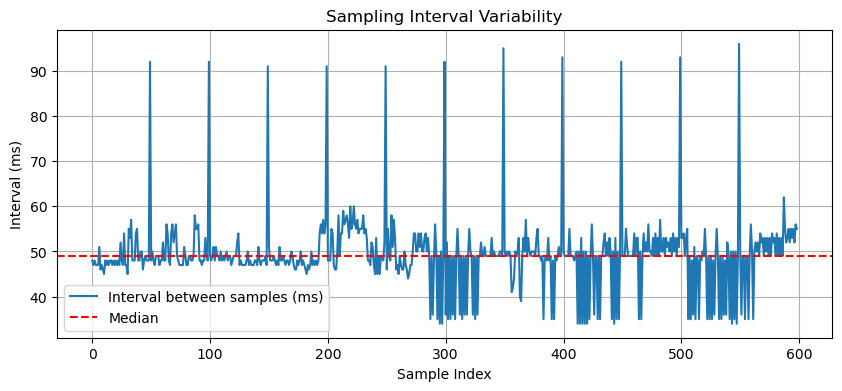

Median interval: 49.00 ms
Mean interval: 49.37 ms
Std deviation: 7.88 ms


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load segment metadata ---
with open(f"{DATAFILES_DIR}/raw_handgestures_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

train_segments = metadata["train_segments"]

# --- Load tensor data ---
tensor_data = torch.load(f"{DATAFILES_DIR}/raw_handgestures_6channels_dataset.pt", weights_only=False)
train_data = tensor_data["train_data"]

# --- Pick a random segment ---
segment = random.choice(train_segments)
csv_path = segment["file"]
start_index = segment["start_index"]
tensor_index = segment["tensor_index"]

df = pd.read_csv(csv_path)
cols = ['Timestamp(ms)']
timestamps = df[cols].values

timestamps = np.array(timestamps).flatten()  # ensure 1D
intervals = np.diff(timestamps)

plt.figure(figsize=(10, 4))
plt.plot(intervals, label="Interval between samples (ms)")
plt.axhline(y=np.median(intervals), color='r', linestyle='--', label="Median")
plt.title("Sampling Interval Variability")
plt.xlabel("Sample Index")
plt.ylabel("Interval (ms)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Median interval: {np.median(intervals):.2f} ms")
print(f"Mean interval: {np.mean(intervals):.2f} ms")
print(f"Std deviation: {np.std(intervals):.2f} ms")


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load raw data for one axis (change file to other axes or sensors as needed)
acc_x = np.loadtxt(f'{UCIHARFILES_DIR}/train/Inertial Signals/body_acc_x_train.txt')
gyro_z = np.loadtxt(f'{UCIHARFILES_DIR}/train/Inertial Signals/body_gyro_z_train.txt')

# Load the activity labels (1–6)
labels = np.loadtxt(f'{UCIHARFILES_DIR}/train/y_train.txt')

# Pick an example index (e.g., walking sample)
example_index = 0
signal = acc_x[example_index]
gyro = gyro_z[example_index]
label = int(labels[example_index])

activity_names = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}
print("Type of signal:", type(signal))  # Should be <class 'tuple'>
print("Tuple length:", len(signal))     # How many arrays in the tuple

for i, sig in enumerate(signal):
    print(f"Signal[{i}] shape: {sig.shape}, dtype: {sig.dtype}")

Type of signal: <class 'numpy.ndarray'>
Tuple length: 128
Signal[0] shape: (), dtype: float64
Signal[1] shape: (), dtype: float64
Signal[2] shape: (), dtype: float64
Signal[3] shape: (), dtype: float64
Signal[4] shape: (), dtype: float64
Signal[5] shape: (), dtype: float64
Signal[6] shape: (), dtype: float64
Signal[7] shape: (), dtype: float64
Signal[8] shape: (), dtype: float64
Signal[9] shape: (), dtype: float64
Signal[10] shape: (), dtype: float64
Signal[11] shape: (), dtype: float64
Signal[12] shape: (), dtype: float64
Signal[13] shape: (), dtype: float64
Signal[14] shape: (), dtype: float64
Signal[15] shape: (), dtype: float64
Signal[16] shape: (), dtype: float64
Signal[17] shape: (), dtype: float64
Signal[18] shape: (), dtype: float64
Signal[19] shape: (), dtype: float64
Signal[20] shape: (), dtype: float64
Signal[21] shape: (), dtype: float64
Signal[22] shape: (), dtype: float64
Signal[23] shape: (), dtype: float64
Signal[24] shape: (), dtype: float64
Signal[25] shape: (), dtype

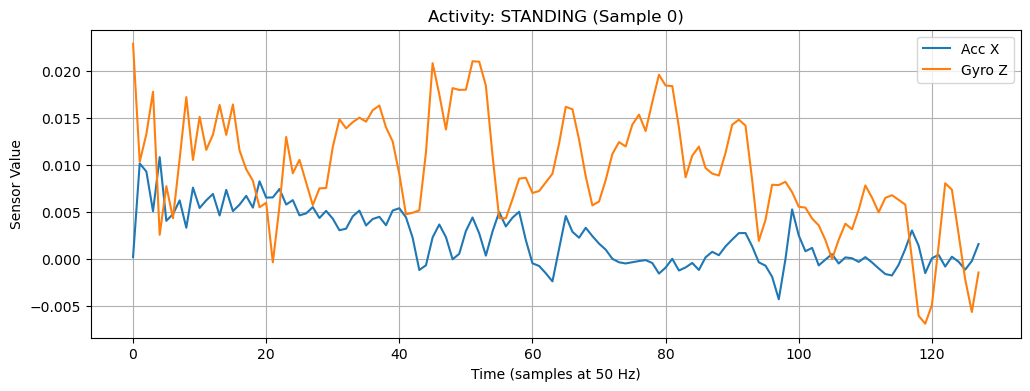

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(signal, label='Acc X')
plt.plot(gyro, label='Gyro Z')
plt.title(f"Activity: {activity_names[label]} (Sample {example_index})")
plt.xlabel("Time (samples at 50 Hz)")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# # Load the dataset
# data = torch.load(f"{DATAFILES_DIR}/raw_handgestures_6channels_filepaths.pt")

# # Extract variables
# train_paths = data["train_paths"]
# train_labels = data["train_labels"]
# test_paths = data["test_paths"]
# test_labels = data["test_labels"]

# Load the pickled dictionary
with open(f"{DATAFILES_DIR}/raw_handgestures_metadata.pkl", 'rb') as f:
    raw_fileset = pickle.load(f)

# Access the contents
train_paths = raw_fileset["train_segments"]
test_paths = raw_fileset["test_segments"]

# # Load the dataset
# data = torch.load(f"{DATAFILES_DIR}/raw_handgestures_6channels_dataset.pt")

# # Extract variables
# train_paths = data["train_segments"]
# test_paths = data["test_segments"]

# print(train_paths)

Comparing file: ../data-collections/Phillip/tremor/running/variants/DATA3_variants_scale2_9.CSV
Tensor index: 20712, Start index in CSV: 0
torch.Size([127, 6])
CSV slice mean/std:
[-0.07329281 -0.02680492 -0.03277219 -0.06702873 -0.02210249 -0.17361173] [0.9599185  1.0748273  0.9459897  1.0215915  1.0586749  0.96182805]
Tensor slice mean/std:
[ 2.81596746e-09  5.63193492e-09  8.44790282e-09  1.87144504e-08
 -1.64264762e-08 -1.31411815e-08] [0.99999887 0.99999726 0.99999845 1.         0.99999994 1.        ]


/var/folders/b0/gfhb3q152fj7dx14t68p8cch0000gn/T/ipykernel_2605/1939729496.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10').colors  # 10 distinct colors


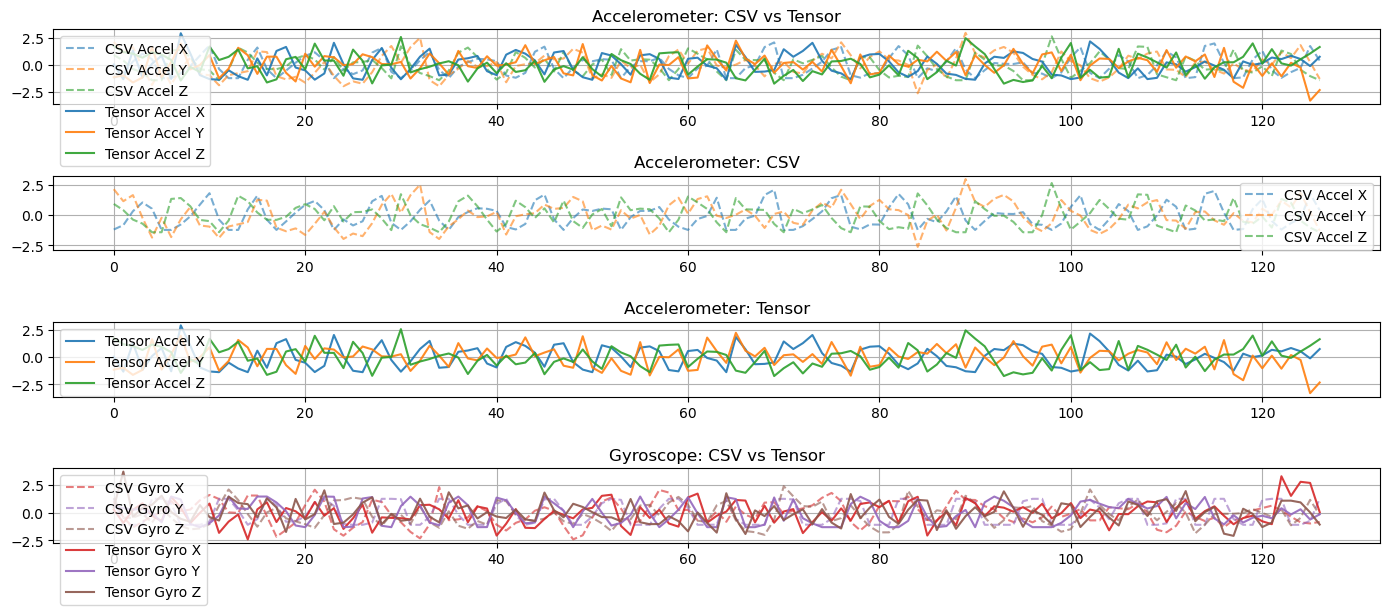

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import pickle

def normalize_signal(data):
    return (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-6)

def extract_tensor_from_csv_with_index(csv_path, target_len=127):
    df = pd.read_csv(csv_path)
    cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
    data = df[cols].values
    data = normalize_signal(data)
    
    if len(data) >= target_len:
        start_index = (len(data) - target_len) // 2
        data = data[start_index:start_index + target_len, :]
    else:
        start_index = 0
        pad_width = target_len - len(data)
        pad = np.zeros((pad_width, data.shape[1]), dtype=np.float32)
        data = np.vstack([data, pad])
    
    return data.astype(np.float32), start_index

# --- Load segment metadata ---
with open(f"{DATAFILES_DIR}/raw_handgestures_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

train_segments = metadata["train_segments"]

# --- Load tensor data ---
tensor_data = torch.load(f"{DATAFILES_DIR}/raw_handgestures_6channels_dataset.pt", weights_only=False)
train_data = tensor_data["train_data"]

# --- Pick a random segment ---
segment = random.choice(train_segments)
csv_path = segment["file"]
start_index = segment["start_index"]
tensor_index = segment["tensor_index"]


# csv_path = train_segments[idx]["file"]
# start_index = train_segments[idx]["start_index"]
# tensor_window = train_data[train_segments[idx]["tensor_index"]].numpy()

# df = pd.read_csv(csv_path)
# cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
#         'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
# csv_values = df[cols].values
# csv_normalized = normalize_signal(csv_values)

csv_slice, csv_start_index = extract_tensor_from_csv_with_index(csv_path)

# csv_slice = csv_normalized[start_index:start_index + 127]

# # pad if needed
# if len(csv_slice) < 127:
#     pad = np.zeros((127 - len(csv_slice), 6), dtype=np.float32)
#     csv_slice = np.vstack([csv_slice, pad])

print(f"Comparing file: {csv_path}")
print(f"Tensor index: {tensor_index}, Start index in CSV: {start_index}")

# # --- Load CSV and extract relevant columns ---
# df = pd.read_csv(csv_path)
# df_values = df[['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']].values

# # --- Slice 127 samples from the CSV using start_index ---
# csv_slice = df_values[start_index:start_index + 127]

# --- Get corresponding tensor (already normalized and shaped) ---
tensor_window = train_data[tensor_index].numpy()

print("CSV slice mean/std:")
# print(type(csv_slice))
# print(csv_slice)
print(csv_slice.mean(axis=0), csv_slice.std(axis=0))

print("Tensor slice mean/std:")
print(tensor_window.mean(axis=0), tensor_window.std(axis=0))

# # Normalize the same way as the tensor
# normalized_csv_slice = (csv_slice - csv_slice.mean(axis=0)) / (csv_slice.std(axis=0) + 1e-6)

# # --- Match slice/padding logic exactly ---
# if len(df_values) >= 127:
#     csv_slice = df_values[start_index:start_index + 127]
# else:
#     pad_width = 127 - len(df_values)
#     csv_slice = np.vstack([df_values, np.zeros((pad_width, df_values.shape[1]))])

# # --- Normalize CSV slice like tensor ---
# normalized_csv_slice = (csv_slice - csv_slice.mean(axis=0)) / (csv_slice.std(axis=0) + 1e-6)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Use a consistent colormap ---
colors = cm.get_cmap('tab10').colors  # 10 distinct colors

fig, axs = plt.subplots(4, 1, figsize=(14, 6))

# --- Accelerometer comparison ---
axs[0].plot(csv_slice[:, 0], label="CSV Accel X", linestyle="--", color=colors[0], alpha=0.6)
axs[0].plot(csv_slice[:, 1], label="CSV Accel Y", linestyle="--", color=colors[1], alpha=0.6)
axs[0].plot(csv_slice[:, 2], label="CSV Accel Z", linestyle="--", color=colors[2], alpha=0.6)

axs[0].plot(tensor_window[:, 0], label="Tensor Accel X", linestyle="-", color=colors[0], alpha=0.9)
axs[0].plot(tensor_window[:, 1], label="Tensor Accel Y", linestyle="-", color=colors[1], alpha=0.9)
axs[0].plot(tensor_window[:, 2], label="Tensor Accel Z", linestyle="-", color=colors[2], alpha=0.9)

axs[0].set_title("Accelerometer: CSV vs Tensor")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(csv_slice[:, 0], label="CSV Accel X", linestyle="--", color=colors[0], alpha=0.6)
axs[1].plot(csv_slice[:, 1], label="CSV Accel Y", linestyle="--", color=colors[1], alpha=0.6)
axs[1].plot(csv_slice[:, 2], label="CSV Accel Z", linestyle="--", color=colors[2], alpha=0.6)

axs[1].set_title("Accelerometer: CSV")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(tensor_window[:, 0], label="Tensor Accel X", linestyle="-", color=colors[0], alpha=0.9)
axs[2].plot(tensor_window[:, 1], label="Tensor Accel Y", linestyle="-", color=colors[1], alpha=0.9)
axs[2].plot(tensor_window[:, 2], label="Tensor Accel Z", linestyle="-", color=colors[2], alpha=0.9)

axs[2].set_title("Accelerometer: Tensor")
axs[2].legend()
axs[2].grid(True)

# --- Gyroscope comparison ---
axs[3].plot(csv_slice[:, 3], label="CSV Gyro X", linestyle="--", color=colors[3], alpha=0.6)
axs[3].plot(csv_slice[:, 4], label="CSV Gyro Y", linestyle="--", color=colors[4], alpha=0.6)
axs[3].plot(csv_slice[:, 5], label="CSV Gyro Z", linestyle="--", color=colors[5], alpha=0.6)

axs[3].plot(tensor_window[:, 3], label="Tensor Gyro X", linestyle="-", color=colors[3], alpha=0.9)
axs[3].plot(tensor_window[:, 4], label="Tensor Gyro Y", linestyle="-", color=colors[4], alpha=0.9)
axs[3].plot(tensor_window[:, 5], label="Tensor Gyro Z", linestyle="-", color=colors[5], alpha=0.9)

axs[3].set_title("Gyroscope: CSV vs Tensor")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

Columns in CSV: ['Timestamp(ms)', 'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)', 'DistanceLeft(cm)', 'DistanceRight(cm)']
First few rows:
    Timestamp(ms)  AccelX(g)  AccelY(g)  AccelZ(g)  GyroX(deg/s)  GyroY(deg/s)  \
0          22909     -0.023      0.045      1.078        -9.244        -2.503   
1          22959     -0.007      0.026      1.076        -3.809         0.620   
2          23007     -0.009      0.040      1.064        -0.019         4.779   
3          23055     -0.019      0.047      1.075         0.173         1.330   
4          23103      0.004      0.029      1.040        -0.203        -0.909   

   GyroZ(deg/s)  DistanceLeft(cm)  DistanceRight(cm)  
0        -1.875                10                134  
1         1.163                10                134  
2         4.603                 6                135  
3         4.832                 7                135  
4         5.023                 6                135  


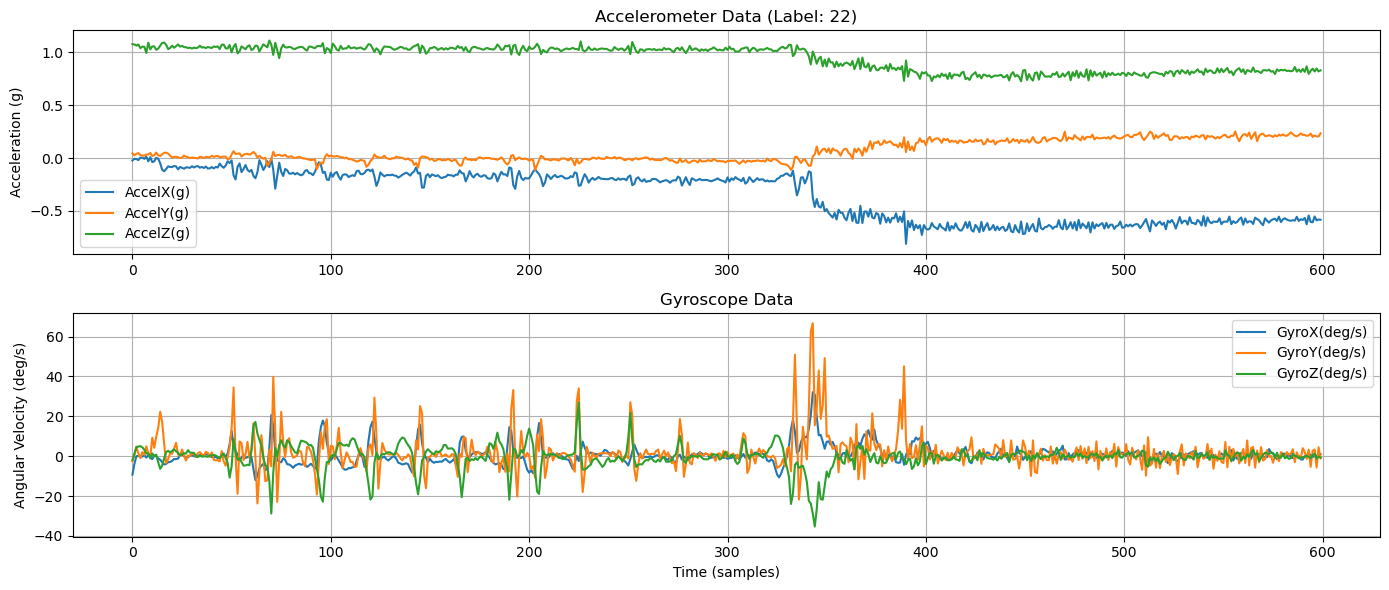

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Invert label_dict if needed (optional, depends on your workflow)
# inv_label_dict = {v: k for k, v in label_dict.items()}

# Pick a sample index to visualize
idx = 0
csv_path = train_paths[idx]
label = train_labels[idx]  # Can be int or string depending on how you saved it

# Load CSV
df = pd.read_csv(csv_path)

# Optional: Print columns to verify
print("Columns in CSV:", df.columns.tolist())
print("First few rows:\n", df.head())

# Assuming your columns include these names:
accel_cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)']
gyro_cols = ['GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']

# Plot
plt.figure(figsize=(14, 6))

# Accelerometer
plt.subplot(2, 1, 1)
for col in accel_cols:
    plt.plot(df[col], label=col)
plt.title(f"Accelerometer Data (Label: {label})")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid(True)

# Gyroscope
plt.subplot(2, 1, 2)
for col in gyro_cols:
    plt.plot(df[col], label=col)
plt.title("Gyroscope Data")
plt.ylabel("Angular Velocity (deg/s)")
plt.xlabel("Time (samples)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


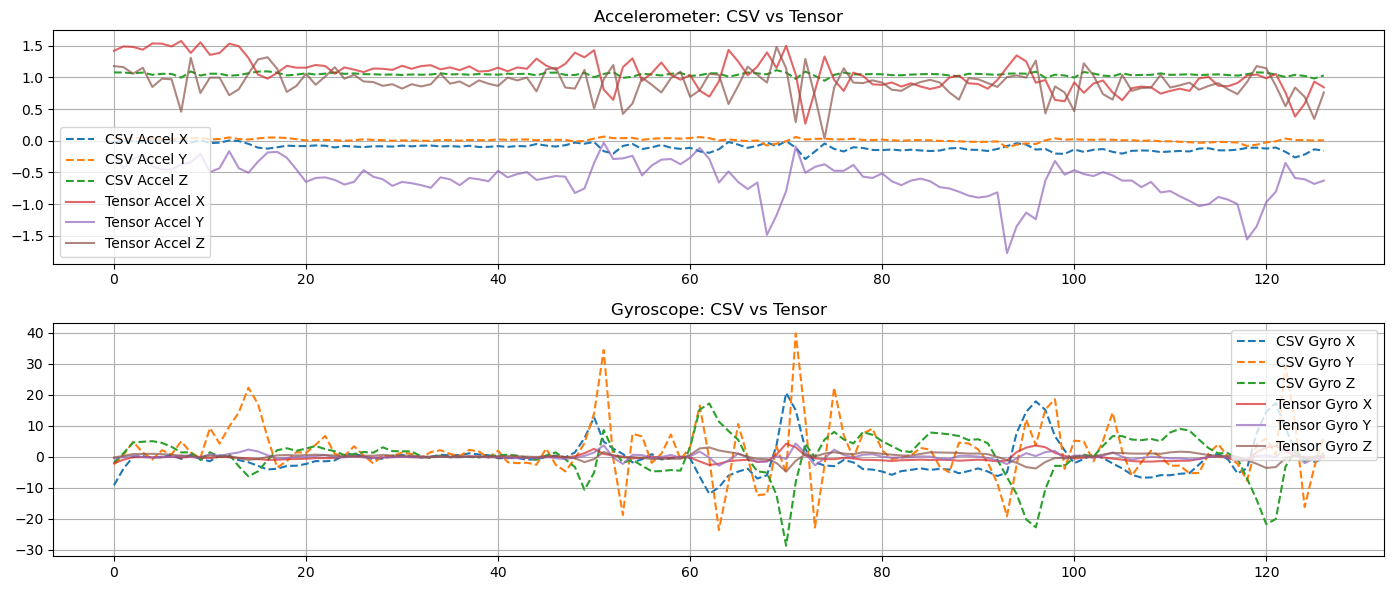

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

# --- Choose index to compare ---
idx = 0
csv_path = train_paths[idx]
tensor_window = train_data[idx]  # Shape: (127, 6)

# --- Load CSV and extract relevant columns ---
df = pd.read_csv(csv_path)
df_values = df[['AccelX(g)', 'AccelY(g)', 'AccelZ(g)','GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']].values

# Optional: Trim CSV to 127 rows if it's longer (your model uses windowed slices)
df_values = df_values[:127]

# --- Convert tensor to numpy ---
tensor_values = tensor_window

# --- Plot comparison (overlay) ---
fig, axs = plt.subplots(2, 1, figsize=(14, 6))

# Accelerometer comparison
axs[0].plot(df_values[:, 0], label="CSV Accel X", linestyle="--")
axs[0].plot(df_values[:, 1], label="CSV Accel Y", linestyle="--")
axs[0].plot(df_values[:, 2], label="CSV Accel Z", linestyle="--")

axs[0].plot(tensor_values[:, 0], label="Tensor Accel X", alpha=0.7)
axs[0].plot(tensor_values[:, 1], label="Tensor Accel Y", alpha=0.7)
axs[0].plot(tensor_values[:, 2], label="Tensor Accel Z", alpha=0.7)

axs[0].set_title("Accelerometer: CSV vs Tensor")
axs[0].legend()
axs[0].grid(True)

# Gyroscope comparison
axs[1].plot(df_values[:, 3], label="CSV Gyro X", linestyle="--")
axs[1].plot(df_values[:, 4], label="CSV Gyro Y", linestyle="--")
axs[1].plot(df_values[:, 5], label="CSV Gyro Z", linestyle="--")

axs[1].plot(tensor_values[:, 3], label="Tensor Gyro X", alpha=0.7)
axs[1].plot(tensor_values[:, 4], label="Tensor Gyro Y", alpha=0.7)
axs[1].plot(tensor_values[:, 5], label="Tensor Gyro Z", alpha=0.7)

axs[1].set_title("Gyroscope: CSV vs Tensor")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


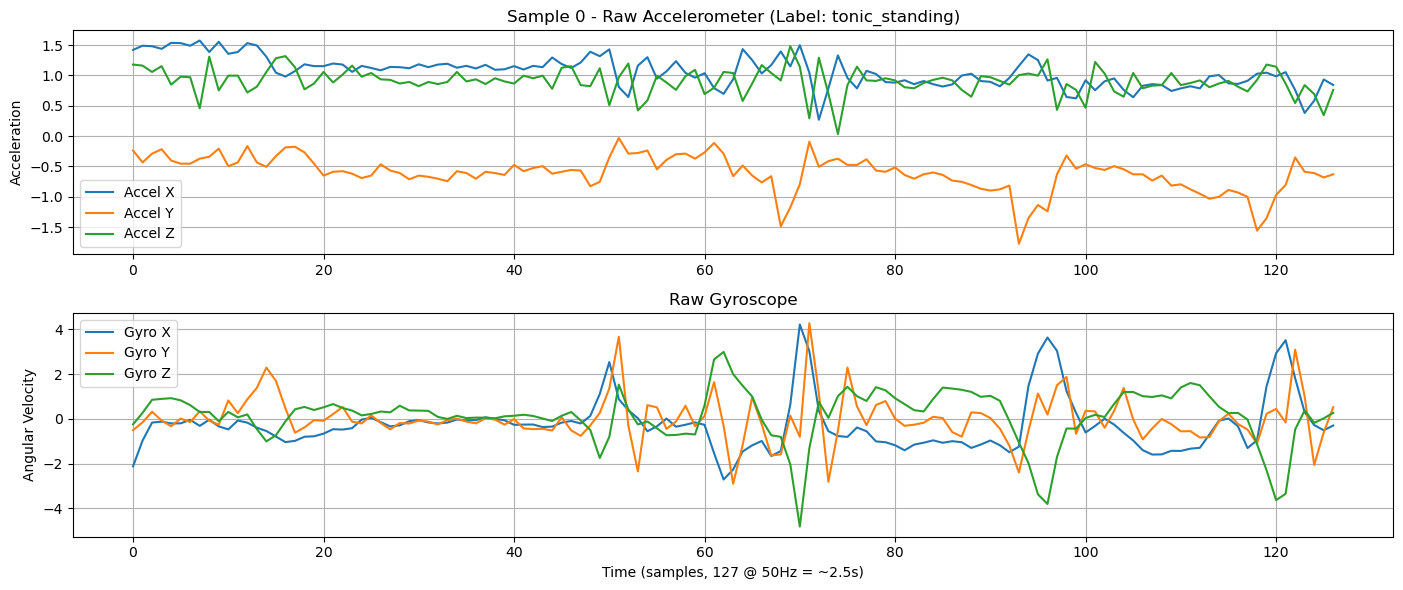

In [37]:
# Reverse label_dict for label decoding
inv_label_dict = {v: k for k, v in label_dict.items()}

# Pick a sample index (e.g., 0, or random)
sample_idx = 0
signal = train_data[sample_idx]               # shape: (127, 6)
label_id = train_labels[sample_idx].item()
label_name = inv_label_dict[label_id]

# Split channels
accel_x = signal[:, 0]
accel_y = signal[:, 1]
accel_z = signal[:, 2]
gyro_x = signal[:, 3]
gyro_y = signal[:, 4]
gyro_z = signal[:, 5]

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(accel_x, label='Accel X')
plt.plot(accel_y, label='Accel Y')
plt.plot(accel_z, label='Accel Z')
plt.title(f"Sample {sample_idx} - Raw Accelerometer (Label: {label_name})")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(gyro_x, label='Gyro X')
plt.plot(gyro_y, label='Gyro Y')
plt.plot(gyro_z, label='Gyro Z')
plt.title("Raw Gyroscope")
plt.ylabel("Angular Velocity")
plt.xlabel("Time (samples, 127 @ 50Hz = ~2.5s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Load the model

Load the model you want to test out the validation

In [4]:
# In a new script
#model = MPSCNN(num_classes)
# model.load_state_dict(torch.load("handgestures_trained_model_weights_97percent.pt", map_location=device))
# model = MPSCNN_6chan(num_classes)
# model.load_state_dict(torch.load("handgestures_trained_6-channel_model_weights_97percent.pt", map_location=device))

#model = CNNLSTM(input_channels=6, num_classes=num_classes)
#model.load_state_dict(torch.load("Models/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt", map_location=device))
model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes)
model.load_state_dict(torch.load("Models/handgestures_trained_6-channel_CNN-LSTM-PSD_model_weights_97percent.pt", map_location=device))

model = CNNLSTMWithAttentionAndGatedFusionAndTCN(input_channels=input_shape[2], psd_dim=psd_vector_dim, num_classes=num_classes)

model.to(device)

NameError: name 'psd_vector_dim' is not defined

## Random Prediction

Pick a random sample from the UCI HAR wavelets and do a prediction

In [33]:
import torch
import numpy as np
import pywt
import random
from scipy.signal import welch

# -- Wavelet Transform Parameters --
scales = range(1, 128)
wavelet = 'morl'

# -- CWT computation --
def compute_cwt(signal_1d, device, scales=scales, wavelet=wavelet):
    signal_np = signal_1d.cpu().numpy() if isinstance(signal_1d, torch.Tensor) else signal_1d
    coeff, _ = pywt.cwt(signal_np, scales, wavelet, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

# -- PSD computation --
def compute_psd(signal_1d, fs=50, nperseg=128):
    """
    Compute PSD from a 1D signal using Welch's method.
    """
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd  # shape: (n_freq_bins,)

# -- Preprocessing for a single sample (CWT only) --
def preprocess_sample(raw_sample, device, expected_channels=6):
    # Normalize each channel (per-sample)
    raw_sample = (raw_sample - raw_sample.mean(axis=0)) / (raw_sample.std(axis=0) + 1e-6)

    channels = []
    for i in range(raw_sample.shape[1]):
        cwt_tensor = compute_cwt(torch.tensor(raw_sample[:, i]), device)
        channels.append(cwt_tensor.unsqueeze(0))  # (1, height, width)

    stacked = torch.cat(channels, dim=0)  # (channels, height, width)

    # Ensure correct number of channels (pad or trim)
    if stacked.shape[0] < expected_channels:
        padding = torch.zeros((expected_channels - stacked.shape[0], 127, 127), device=device)
        stacked = torch.cat([stacked, padding], dim=0)
    elif stacked.shape[0] > expected_channels:
        stacked = stacked[:expected_channels]

    # Add batch and time dimensions
    stacked = stacked.unsqueeze(0).unsqueeze(1)  # (1, 1, C, H, W)

    return stacked

# -- Full prediction with real PSD --
def predict_single_sample(raw_sample, model, device, index_to_label=None):
    # Preprocess CWT
    model_input = preprocess_sample(raw_sample, device, expected_channels=6)  # (1, 1, C, H, W)

    # Compute PSD features
    psd_channels = []
    for i in range(raw_sample.shape[1]):
        psd = compute_psd(raw_sample[:, i])  # (n_freq_bins,)
        psd_channels.append(psd)

    psd_vector = np.concatenate(psd_channels)  # shape: (C * bins,)
    psd_tensor = torch.tensor(psd_vector, dtype=torch.float32, device=device).unsqueeze(0)  # (1, D)

    # Match expected PSD input shape
    expected_psd_dim = model.psd_branch[0].in_features
    if psd_tensor.shape[1] > expected_psd_dim:
        psd_tensor = psd_tensor[:, :expected_psd_dim]
    elif psd_tensor.shape[1] < expected_psd_dim:
        pad = torch.zeros((1, expected_psd_dim - psd_tensor.shape[1]), device=device)
        psd_tensor = torch.cat([psd_tensor, pad], dim=1)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(model_input, psd_tensor)
        prediction = torch.argmax(output, dim=1).item()

    if index_to_label:
        return prediction, index_to_label[prediction]
    return prediction

# -- Random Test Prediction Example --
sample_index = random.randint(0, len(test_data) - 1)
sample = test_data[sample_index]
#true_label_int = test_labels[sample_index] + 1  # shift if 1-based
true_label_int = test_labels[sample_index]
true_label_name = activity_labels.get(true_label_int, "Unknown")

# Predict
predicted_index, predicted_name = predict_single_sample(sample, model, device, index_to_label=index_to_label)
predicted_label = next(k for k, v in label_dict.items() if v == predicted_index)

# Output
print(f"\nSample index: {sample_index}")
print(f"True label int: {true_label_int}")
print(f"True label name: {true_label_name}")
print(f"Predicted label index: {predicted_index}")
print(f"Predicted label name: {predicted_label}")


Sample index: 1586
True label int: 4
True label name: SITTING
Predicted label index: 4
Predicted label name: WALKING_UPSTAIRS


In [34]:
import numpy as np
import torch
from scipy.signal import welch

def normalize_sample(sample):
    """
    Normalize each channel in a sample (127, C) to zero mean and unit variance.
    Returns: normalized sample of shape (127, C)
    """
    mean = np.mean(sample, axis=0, keepdims=True)
    std = np.std(sample, axis=0, keepdims=True)
    std[std == 0] = 1e-6  # Prevent division by zero
    return (sample - mean) / std

def compute_psd(signal_1d, fs=50, nperseg=128):
    """
    Compute PSD from a 1D signal using Welch's method.
    """
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd

def preprocess_batch(raw_batch, device, expected_channels=6):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, 1, expected_channels, 127, 127)
    """
    batch_size = raw_batch.shape[0]
    processed = []
    for i in range(batch_size):
        norm_sample = normalize_sample(raw_batch[i])  # shape (127, C)
        sample_tensor = preprocess_sample(norm_sample, device, expected_channels)  # shape (1,1,C,H,W)
        processed.append(sample_tensor)
    return torch.cat(processed, dim=0)  # (batch_size, 1, expected_channels, 127, 127)

def compute_batch_psd(raw_batch):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, PSD_feature_dim)
    """
    batch_psd = []
    for sample in raw_batch:
        psd_channels = []
        for c in range(sample.shape[1]):
            psd = compute_psd(sample[:, c])  # shape (n_freq_bins,)
            psd_channels.append(psd)
        psd_vector = np.concatenate(psd_channels)  # (C * n_freq_bins,)
        batch_psd.append(psd_vector)
    batch_psd = np.stack(batch_psd)  # (batch_size, PSD_feature_dim)
    return torch.tensor(batch_psd, dtype=torch.float32)

def predict_batch(raw_batch, raw_labels, model, device, index_to_label=None, label_dict=None):
    """
    raw_batch: numpy array (batch_size, 127, C)
    raw_labels: numpy array or list of true label indices (batch_size,)
    """
    model_input = preprocess_batch(raw_batch, device, expected_channels=6)  # (B, 1, C, 127, 127)
    batch_size = model_input.shape[0]

    # Compute PSD features for batch
    psd_tensor = compute_batch_psd(raw_batch).to(device)  # (B, PSD_feature_dim)

    # Match expected PSD input dimension
    expected_psd_dim = model.psd_branch[0].in_features
    if psd_tensor.shape[1] > expected_psd_dim:
        psd_tensor = psd_tensor[:, :expected_psd_dim]
    elif psd_tensor.shape[1] < expected_psd_dim:
        pad = torch.zeros((batch_size, expected_psd_dim - psd_tensor.shape[1]), device=device)
        psd_tensor = torch.cat([psd_tensor, pad], dim=1)

    model.eval()
    with torch.no_grad():
        outputs = model(model_input.to(device), psd_tensor)  # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Reverse label index to name if provided
    pred_names = None
    if index_to_label:
        index_to_label_inv = {v: k for k, v in index_to_label.items()}
        pred_names = [index_to_label_inv.get(p, "Unknown") for p in preds]

    true_names = None
    if label_dict is not None and raw_labels is not None:
        true_names = [label_dict.get(lbl, "Unknown") for lbl in raw_labels]

    return preds, pred_names, raw_labels, true_names


# --- Usage example with random batch ---
batch_size = 10
total_samples = len(test_data)

random_indices = np.random.choice(total_samples, size=batch_size, replace=False)
batch_samples = test_data[random_indices]   # shape (10, 127, C)
batch_labels = test_labels[random_indices]   # shape (10,)

predicted_indices, predicted_labels, true_indices, true_labels = predict_batch(
    batch_samples, batch_labels, model, device,
    index_to_label=label_dict,   # label index->name map
    label_dict=activity_labels   # int label->human name map
)

print("Random Indices:", random_indices)
print("Predicted indices:", predicted_indices)
print("Predicted labels:", predicted_labels)
print("True indices:", true_indices)
print("True labels:", true_labels)

Random Indices: [ 516  736  821 1173 2189 1823 1993 2832 2599 1512]
Predicted indices: [0 0 0 1 0 0 0 4 0 0]
Predicted labels: ['LAYING', 'LAYING', 'LAYING', 'SITTING', 'LAYING', 'LAYING', 'LAYING', 'WALKING_UPSTAIRS', 'LAYING', 'LAYING']
True indices: [4 6 6 5 4 2 3 3 2 1]
True labels: ['SITTING', 'LAYING', 'LAYING', 'STANDING', 'SITTING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'WALKING']


In [29]:
from sklearn.metrics import classification_report

def print_precision_recall(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Per-Class Precision, Recall, and F1:")
    print(report)

# Assuming you have predictions
y_true = y_test_seq_last.cpu().numpy()
y_pred = model(x_test_seq.to(device), psd_test_seq_padded.to(device)).argmax(dim=1).cpu().numpy()

# Class names
class_names = ['normal', 'tonic', 'tremor', 'postural']  # <- customize as needed

#plot_confusion_matrix(y_true, y_pred, class_names)
print_precision_recall(y_true, y_pred, class_names)

RuntimeError: MPS backend out of memory (MPS allocated: 12.79 GB, other allocations: 3.33 MB, max allowed: 21.33 GB). Tried to allocate 10.38 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Visualizations

Insights that were gathered from the data training and validation work

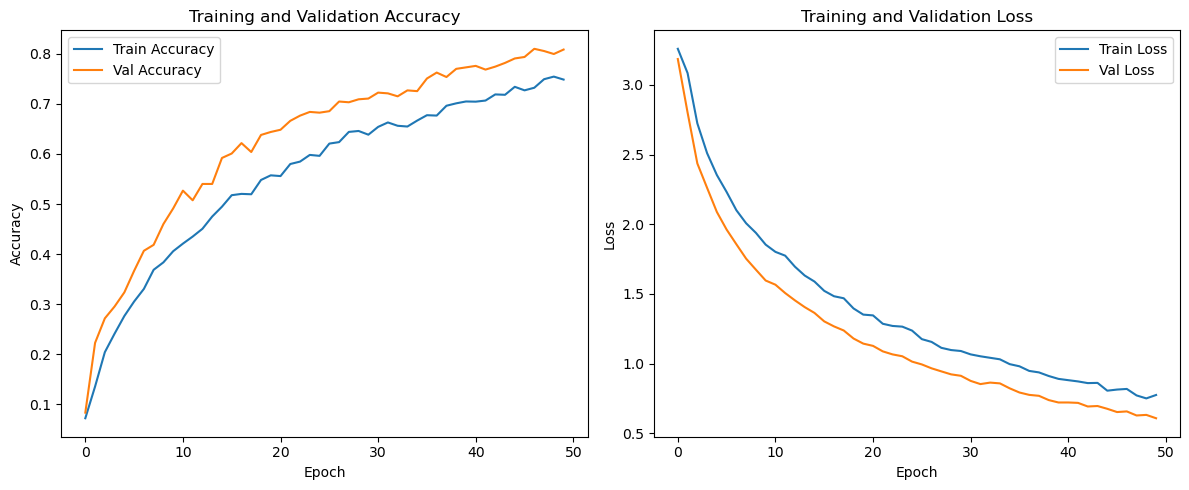

In [36]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


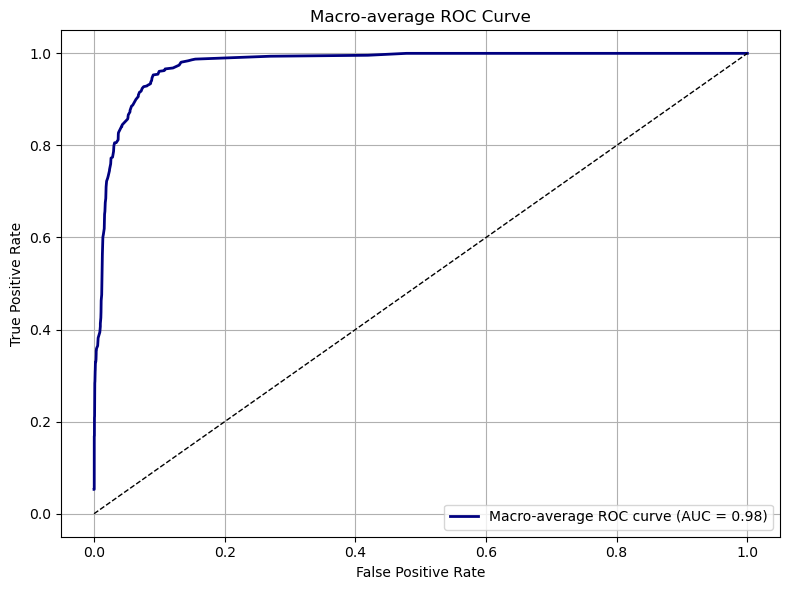

In [10]:
def compute_roc_auc(model, loader, n_classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
            torch.mps.empty_cache()

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    # One-hot encode the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Compute and plot ROC-AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, num_classes)

plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
unique_classes = np.unique(y_train)  # or use y_train_tensor.cpu().numpy()
print(unique_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]


In [15]:
class_to_index = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
print(class_to_index)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97}
